#1.Imports

In [73]:
!pip install surprise

In [2]:
!pip install datasketch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 2.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split
import itertools
from sklearn.metrics import jaccard_score
import datetime
from surprise import Dataset, Reader, SVD
from surprise import accuracy
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from itertools import product
import heapq
from datasketch import MinHash, MinHashLSH
from random import randrange, uniform

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#2.See data and make the dataset

##2.1 Lastfm dataset

In [323]:
lastfm_df = pd.read_csv('Last.fm_data.csv')
lastfm_df.head()

Unnamed: 0 Username           Artist                          Track  \
0           0  Babs_05  Isobel Campbell     The Circus Is Leaving Town   
1           1  Babs_05  Isobel Campbell                   Dusty Wreath   
2           2  Babs_05  Isobel Campbell     Honey Child What Can I Do?   
3           3  Babs_05  Isobel Campbell  It's Hard To Kill A Bad Thing   
4           4  Babs_05  Isobel Campbell                Saturday's Gone   

                       Album         Date    Time  
0  Ballad of the Broken Seas  31 Jan 2021   23:36  
1  Ballad of the Broken Seas  31 Jan 2021   23:32  
2  Ballad of the Broken Seas  31 Jan 2021   23:28  
3  Ballad of the Broken Seas  31 Jan 2021   23:25  
4  Ballad of the Broken Seas  31 Jan 2021   23:21

In [324]:
lastfm_df.drop(['Unnamed: 0'], inplace=True, axis=1)


In [325]:
# Standardize track name and artist columns
lastfm_df['Track'] = lastfm_df['Track'].str.lower().str.strip()
lastfm_df['Artist'] = lastfm_df['Artist'].str.lower().str.strip()

In [326]:
#make lower case the columns names
lastfm_df.columns=lastfm_df.columns.str.lower()

##2.2 Spotify Dataset

In [327]:
spotify_df = pd.read_csv('dataset.csv')
spotify_df.head()

<ipython-input-327-e337b98a33c8>:1: DtypeWarning: Columns (7,9,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  spotify_df = pd.read_csv('dataset.csv')


Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms explicit  danceability  \
0                      Comedy        73.0     230666.0    False         0.676   
1            Ghost - Acoustic        55.0     149610.0    False         0.420   
2              To Begin Again        57.0     210826.0    False         0.438   
3  Can't Help Falling In Love        71.0     201933.0    False         0.266   
4                     Hold On        82.0     198853.0    False         0.618   

   energy  key loudness mode  speechiness  acousticness  instrumentalness  \
0   0.461  1.0   -6.746    0       0.1430        0.0322          0.000001   
1   0.166  1.0  -17.235    1       0.0763        0.9240          0.000006   
2   0.359  0.0   -9.734    1       0.0557        0.2100          0.000000   
3  0.0596  0.0  -18.515    1       0.0363        0.9050          0.000071   
4   0.443  2.0   -9.681    1       0.0526        0.4690          0.000000   

   liveness  valence    tempo  time_signature track_genre  
0    0.3580    0.715   87.917             4.0    acoustic  
1    0.1010    0.267   77.489             4.0    acoustic  
2    0.1170    0.120   76.332             4.0    acoustic  
3    0.1320    0.143  181.740             3.0    acoustic  
4    0.0829    0.167  119.949             4.0    acoustic

In [328]:
spotify_df.drop(['Unnamed: 0'], inplace=True, axis=1)
(spotify_df.head())

track_id                 artists  \
0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms explicit  danceability  \
0                      Comedy        73.0     230666.0    False         0.676   
1            Ghost - Acoustic        55.0     149610.0    False         0.420   
2              To Begin Again        57.0     210826.0    False         0.438   
3  Can't Help Falling In Love        71.0     201933.0    False         0.266   
4                     Hold On        82.0     198853.0    False         0.618   

   energy  key loudness mode  speechiness  acousticness  instrumentalness  \
0   0.461  1.0   -6.746    0       0.1430        0.0322          0.000001   
1   0.166  1.0  -17.235    1       0.0763        0.9240          0.000006   
2   0.359  0.0   -9.734    1       0.0557        0.2100          0.000000   
3  0.0596  0.0  -18.515    1       0.0363        0.9050          0.000071   
4   0.443  2.0   -9.681    1       0.0526        0.4690          0.000000   

   liveness  valence    tempo  time_signature track_genre  
0    0.3580    0.715   87.917             4.0    acoustic  
1    0.1010    0.267   77.489             4.0    acoustic  
2    0.1170    0.120   76.332             4.0    acoustic  
3    0.1320    0.143  181.740             3.0    acoustic  
4    0.0829    0.167  119.949             4.0    acoustic

In [329]:
spotify_df['track_name'] = spotify_df['track_name'].str.lower().str.strip()
spotify_df['artists'] = spotify_df['artists'].str.lower().str.strip()

##2.3 See if the datasets have common tracks to merge them

In [330]:
#find common tracks on both dataset and print also the artists on common tracks


common_tracks = set(lastfm_df['track']).intersection(set(spotify_df['track_name']))
if common_tracks:
    print(f"Common tracks: {common_tracks}")
else:
    print("No common tracks found.")

print(len(common_tracks))




Common tracks: {'adrift', "life's what you make it", 'beamer boy', 'the rose', 'boogeymen', 'n.y. state of mind', 'struggle', 'the boy is mine', 'apache', 'a star is born', 'последняя дискотека', 'parasite eve', 'en el último trago', 'planet x', 'sleep well, my angel', 'fat bottomed girls', 'happy together', 'a lannister always pays his debts', 'under', 'dumb', 'midas', 'we gotta get out of this place', 'the resistance', 'bbibbi', 'do or die', 'i walk the line', 'rosyln', 'julia', 'relic', 'their law', 'press', 'style', 'take it on the run', "we don't care", 'raise hell', 'rain', 'headlines', 'period', 'leaving earth', 'true love', 'sayonara', 'in for the kill', 'little things', 'fake tales of san francisco', 'lucha de gigantes', 'sex for breakfast', 'the mountain', 'beautiful girl', 'desire - gryffin remix', 'blow the man down', "doin' time", 'one headlight', 'hang on', 'hip hop hooray', 'caleidoscópio - ao vivo', "i ain't never", 'for all you give (feat. lucy rose)', 'horizon', 'bell

##2.4 Display also the artists in common tracks

In [331]:
# Filter datasets for common tracks and then check for matching artists
#common_songs = []

#for t in common_tracks:
    # Get rows from both dataframes where the track names match
    #lastfm_artists = lastfm_df[lastfm_df['Track'] == t]['Artist']
    #spotify_artists = spotify_df[spotify_df['track_name'] == t]['artists']

    # Find common artists for the matched tracks
    #common_artists = set(lastfm_artists).intersection(set(spotify_artists))

    #if common_artists:
        #common_songs.append((t, list(common_artists)))

# Print common tracks with corresponding artists
#if common_songs:
#   print("Common tracks and artists:")
#    for track, artists in common_songs:
#        print(f"Track: {track}, Artists: {', '.join(artists)}")
#else:
#    print("No common tracks with matching artists found.")

# Print total count of common tracks
#print(f"Total common tracks: {len(common_songs)}")


##2.5 merge the 2 datasets in common tracks, artists and albums

In [332]:
# Merge directly on track and artist names (inner join keeps only matching rows)
combined_df = pd.merge(lastfm_df, spotify_df, left_on=['track','artist','album'], right_on=['track_name','artists','album_name'], how='inner')

# Display the merged DataFrame
combined_df.head(15)


username             artist                              track  \
0   Babs_05              bicep                           apricots   
1   Babs_05  christian löffler                              ronda   
2   Babs_05  christian löffler                              ronda   
3   Babs_05  christian löffler                              ronda   
4   Babs_05  christian löffler                              ronda   
5   Babs_05  christian löffler                              ronda   
6   Babs_05           dua lipa                    don't start now   
7   Babs_05             eminem                            rap god   
8   Babs_05            caesars                        jerk it out   
9   Babs_05      groove armada                       superstylin'   
10  Babs_05       bronski beat                      smalltown boy   
11  Babs_05        nik kershaw  i won't let the sun go down on me   
12  Babs_05           autechre                               bike   
13  Babs_05         marshmello                              alone   
14  Babs_05         marshmello                              alone   

                                album         date    time  \
0                            Apricots  19 Jan 2021   18:26   
1                               Ronda  19 Jan 2021   17:24   
2                               Ronda  19 Jan 2021   17:24   
3                               Ronda  19 Jan 2021   17:24   
4                               Ronda  19 Jan 2021   17:24   
5                               Ronda  19 Jan 2021   17:24   
6                     Don't Start Now  30 Jan 2021   16:25   
7   The Marshall Mathers LP2 (Deluxe)  30 Jan 2021   16:19   
8                         Jerk It Out  29 Jan 2021   15:26   
9   Goodbye Country (Hello Nightclub)  29 Jan 2021   14:29   
10                 The Age of Consent  29 Jan 2021   13:42   
11                       Human Racing  29 Jan 2021   13:17   
12                         Incunabula  29 Jan 2021   11:17   
13                              Alone  31 Jan 2021   16:26   
14                              Alone  31 Jan 2021   16:26   

                  track_id            artists  \
0   73X9X7kDgsm4YeHpc8prf6              bicep   
1   4WyhOKXtCkNVcgfTBpYaxm  christian löffler   
2   4WyhOKXtCkNVcgfTBpYaxm  christian löffler   
3   4WyhOKXtCkNVcgfTBpYaxm  christian löffler   
4   4WyhOKXtCkNVcgfTBpYaxm  christian löffler   
5   4WyhOKXtCkNVcgfTBpYaxm  christian löffler   
6   6WrI0LAC5M1Rw2MnX2ZvEg           dua lipa   
7   6or1bKJiZ06IlK0vFvY75k             eminem   
8   1bx7OUl2UmAnA5oZkm9If7            caesars   
9   2yWyFT6bW1Rd9cjVvYi4v8      groove armada   
10  5vmRQ3zELMLUQPo2FLQ76x       bronski beat   
11  65YtzNpiPhGVzg6GPzkotn        nik kershaw   
12  4v9rHzCDgQXbDdB7t4Nwcz           autechre   
13  3MEYFivt6bilQ9q9mFWZ4g         marshmello   
14  3MEYFivt6bilQ9q9mFWZ4g         marshmello   

                           album_name                         track_name  \
0                            Apricots                           apricots   
1                               Ronda                              ronda   
2                               Ronda                              ronda   
3                               Ronda                              ronda   
4                               Ronda                              ronda   
5                               Ronda                              ronda   
6                     Don't Start Now                    don't start now   
7   The Marshall Mathers LP2 (Deluxe)                            rap god   
8                         Jerk It Out                        jerk it out   
9   Goodbye Country (Hello Nightclub)                       superstylin'   
10                 The Age of Consent                      smalltown boy   
11                       Human Racing  i won't let the sun go down on me   
12                         Incunabula                               bike   
13                              Alone                   

In [333]:
# prompt: find lines that all the features are the same except genre , and keep only one line ,with the different genres

# Assuming 'df' is your DataFrame from the previous code
combined_df =combined_df.drop_duplicates(subset=['username', 'track_name', 'artists', 'album_name', 'date', 'time', 'popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'key', 'mode',  'track_id'], keep='first')
#If you want to keep only the first occurence of a duplicate,  use keep = 'first'
#If you want to keep only the last occurence of a duplicate, use keep = 'last'
#If you want to drop all the duplicates, use keep = False

In [334]:
combined_df.shape

(13925, 26)

In [335]:
#see how many different users do we have
unique_users = combined_df['username'].unique()
print(unique_users)
print(len(unique_users))

['Babs_05' 'franhale' 'eartle' 'massdosage' 'Knapster01' 'jonocole'
 'isaac' 'lobsterclaw' 'jajo' 'mremond' 'Orlenay']
11


In [336]:
combined_df.tail(15)

username                artist               track  \
17209  Orlenay           the prodigy              poison   
17210  Orlenay  a tribe called quest     check the rhime   
17211  Orlenay          ever so blue              onthou   
17212  Orlenay          eric badanti   vals de rodrigues   
17213  Orlenay       elliott jacqués        kaleidoscope   
17214  Orlenay            mad season             wake up   
17215  Orlenay                  hole              violet   
17216  Orlenay             pj harvey    when under ether   
17217  Orlenay           kurt cobain  sappy - early demo   
17219  Orlenay             pj harvey   down by the water   
17220  Orlenay           blind melon              change   
17221  Orlenay                  hole              malibu   
17222  Orlenay                  hole          doll parts   
17223  Orlenay             burna boy            ja ara e   
17224  Orlenay              dua lipa               idgaf   

                                      album         date    time  \
17209       Music for the Jilted Generation  02 Jan 2021   19:57   
17210                    The Low End Theory  27 Jan 2021   18:46   
17211                                Traces  31 Jan 2021   20:50   
17212                     Vals De Rodrigues  31 Jan 2021   20:29   
17213                          Kaleidoscope  31 Jan 2021   20:02   
17214                Above (Deluxe Edition)  31 Jan 2021   23:40   
17215                     Live Through This  31 Jan 2021   23:36   
17216                           White Chalk  31 Jan 2021   23:34   
17217  Montage Of Heck: The Home Recordings  31 Jan 2021   23:26   
17219                  To Bring You My Love  31 Jan 2021   22:20   
17220                           Blind Melon  31 Jan 2021   22:11   
17221                        Celebrity Skin  31 Jan 2021   22:07   
17222                     Live Through This  31 Jan 2021   21:47   
17223               The Lion King: The Gift  31 Jan 2021   09:26   
17224                     Dua Lipa (Deluxe)  31 Jan 2021   15:47   

                     track_id               artists  \
17209  6UiDSIFkHMOhW8QxbccGb9           the prodigy   
17210  4HfxDJ0uLHTLe0fZrx0MbQ  a tribe called quest   
17211  0CoSBNNeO8JgayAfLttECk          ever so blue   
17212  3I3WY0C7AQMe6Z6hMUQqd5          eric badanti   
17213  3WiissyVFRpCVrqbyPKZxZ       elliott jacqués   
17214  5xhQOnyRJfRywbEwpkgoTy            mad season   
17215  6CHENx8iqzMwavTIz8s0gm                  hole   
17216  6T74sWvcHvSAO5prlk5dDw             pj harvey   
17217  4le6DvrwMv2rpyN1SPeL0g           kurt cobain   
17219  48mJX8glOrQkrSdVBjc0Wb             pj harvey   
17220  44RW9FEY76mLQCRQUjT0Zt           blind melon   
17221  5bVOX6eyHsML2sB4aMlZEi                  hole   
17222  49t1GWE6ZiEoBgN92oMDdM                  hole   
17223  6pdip6qgVJOI5JxqgbAlu6             burna boy   
17224  76cy1WJvNGJTj78UqeA5zr              dua lipa   

                                 album_name          track_name  popularity  \
17209       Music for the Jilted Generation              poison        48.0   
17210                    The Low End Theory     check the rhime        65.0   
17211                                Traces              onthou        44.0   
17212                     Vals De Rodrigues   vals de rodrigues        49.0   
17213                          Kaleidoscope        kaleidoscope        51.0   
17214                Above (Deluxe Edition)             wake up        53.0   
17215                     Live Through This              violet        63.0   
17216                           White Chalk    when under ether        46.0   
17217  Montage Of Heck: The Home Recordings  sappy - early demo        50.0   
17219                  To Bring You My Love   down by the water        57.0   
17220                           Blind Melon              change        62.0   
17221                        Celebrity Skin              malibu        64.0   
17222                     Live Through This     

#3.Data cleaning

##3.1 See data type for each column

In [337]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13925 entries, 0 to 17224
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   username          13925 non-null  object 
 1   artist            13925 non-null  object 
 2   track             13925 non-null  object 
 3   album             13925 non-null  object 
 4   date              13925 non-null  object 
 5   time              13925 non-null  object 
 6   track_id          13925 non-null  object 
 7   artists           13925 non-null  object 
 8   album_name        13925 non-null  object 
 9   track_name        13925 non-null  object 
 10  popularity        13925 non-null  float64
 11  duration_ms       13925 non-null  float64
 12  explicit          13925 non-null  object 
 13  danceability      13925 non-null  float64
 14  energy            13925 non-null  object 
 15  key               13925 non-null  float64
 16  loudness          13925 non-null  object 
 17

In [338]:
combined_df.columns

Index(['username', 'artist', 'track', 'album', 'date', 'time', 'track_id',
       'artists', 'album_name', 'track_name', 'popularity', 'duration_ms',
       'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'track_genre'],
      dtype='object')

In [339]:
#delete the same columns
combined_df.drop(['track','artist','album'], axis=1, inplace=True)

In [340]:
#convert to lower case
combined_df.columns=combined_df.columns.str.lower()

In [341]:
#find only the int columns
int_cols=combined_df.columns[(combined_df.dtypes == 'int64') | (combined_df.dtypes=='int32')]

#convert the int cols to float
combined_df[int_cols] = combined_df[int_cols].astype(float)


##3.2 Handling duplicates

In [363]:
# Finding duplicate rows (keeping all instances)
duplicate_rows = combined_df[combined_df.duplicated(keep=False)]
duplicate_rows_index=duplicate_rows.index
print(duplicate_rows_index)

Index([   29,    30,    79,    80,  1150,  1151,  1152,  1153,  2189,  2191,
        2536,  2537,  3055,  3056,  3057,  3058,  3143,  3144,  4776,  4778,
        5325,  5327,  5599,  5600,  5601,  5602,  5605,  5606,  6373,  6374,
        8123,  8124,  8195,  8196,  8666,  8667,  8997,  8999,  9852,  9853,
       10321, 10322, 10323, 10324, 10365, 10366, 10629, 10631, 10665, 10666,
       11150, 11151, 11153, 11154, 11676, 11677, 11678, 11679, 12034, 12035,
       12170, 12172, 13245, 13246, 13892, 13893, 14568, 14569],
      dtype='int64')


In [364]:
combined_df= combined_df.drop(duplicate_rows_index)

In [365]:
combined_df.shape

(13857, 23)

##3.3 Fix typo and dtypes of columns

In [366]:
#convert 0.0 in mode in 0
combined_df['mode']=combined_df['mode'].replace(0.0,0)

In [346]:
combined_df = combined_df.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)  # Normalize strings

<ipython-input-346-81d838c02ccb>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  combined_df = combined_df.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)  # Normalize strings


In [367]:
#fix False-->false in explicit column
combined_df['explicit'] = combined_df['explicit'].astype(str).str.lower()

In [368]:
# Ensure all numeric columns are properly typed
numeric_columns = ['popularity', 'duration_ms', 'key', 'loudness', 'danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']
combined_df[numeric_columns] =combined_df[numeric_columns].apply(pd.to_numeric, errors='coerce')


In [369]:
combined_df.head()

username         date   time                track_id            artists  \
0  babs_05  19 jan 2021  18:26  73x9x7kdgsm4yehpc8prf6              bicep   
1  babs_05  19 jan 2021  17:24  4wyhokxtcknvcgftbpyaxm  christian löffler   
4  babs_05  19 jan 2021  17:24  4wyhokxtcknvcgftbpyaxm  christian löffler   
5  babs_05  19 jan 2021  17:24  4wyhokxtcknvcgftbpyaxm  christian löffler   
6  babs_05  30 jan 2021  16:25  6wri0lac5m1rw2mnx2zveg           dua lipa   

        album_name       track_name  popularity  duration_ms explicit  \
0         apricots         apricots        54.0     246506.0    false   
1            ronda            ronda        57.0     346586.0    false   
4            ronda            ronda        57.0     346586.0    false   
5            ronda            ronda        57.0     346586.0    false   
6  don't start now  don't start now        80.0     183290.0    false   

   danceability  energy   key  loudness mode  speechiness  acousticness  \
0         0.819   0.599  11.0    -6.778    1       0.0390        0.3470   
1         0.794   0.307   3.0   -15.629    0       0.0486        0.6740   
4         0.794   0.307   3.0   -15.629    0       0.0486        0.6740   
5         0.794   0.307   3.0   -15.629    0       0.0486        0.6740   
6         0.794   0.793  11.0    -4.521    0       0.0842        0.0125   

   instrumentalness  liveness  valence    tempo  time_signature  \
0             0.824    0.0830    0.489  127.986             4.0   
1             0.935    0.0954    0.171  119.994             4.0   
4             0.935    0.0954    0.171  119.994             4.0   
5             0.935    0.0954    0.171  119.994             4.0   
6             0.000    0.0952    0.677  123.941             4.0   

      track_genre  
0         ambient  
1         ambient  
4  minimal-techno  
5          techno  
6           dance

##3.3 Complete the rating column

In [ ]:
#use popularity to make rating column
#max_popularity=combined_df['popularity'].max()
#min_popularity=combined_df['popularity'].min()
#scale the ratings from 1-5
#combined_df['rating']=1+4*(combined_df['popularity']-min_popularity)/(max_popularity-min_popularity)
#combined_df['rating']=combined_df['rating'].round(2)


In [374]:
#trying to find the lines that has all values of features the same
#except track_genre in order to give the same rating
comparison_columns = combined_df.columns.difference(['track_genre']).tolist()  # Σιγουρεύσου ότι επιστρέφεται λίστα

#find the duplicates
duplicates =combined_df[combined_df.duplicated(subset=comparison_columns, keep=False)]

#groups of lines
groups = duplicates.groupby(comparison_columns).apply(lambda x: list(x.index))
print(len(groups))


1741


<ipython-input-374-ea87f3d6c590>:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  groups = duplicates.groupby(comparison_columns).apply(lambda x: list(x.index))


In [375]:
#check some lines that seeems the same if they are actually the same
#Select the rows by their indices #without column track_genre
columns_to_exclude = ['track_genre']

row_1 = combined_df.loc[1].drop(columns_to_exclude, errors='ignore')
row_4 = combined_df.loc[4].drop(columns_to_exclude, errors='ignore')
row_5 = combined_df.loc[5].drop(columns_to_exclude, errors='ignore')

# Compare rows for equality
are_1_and_4_same = row_1.equals(row_4)
are_4_and_5_same = row_4.equals(row_5)
are_1_and_5_same = row_1.equals(row_5)

print("Are rows 1 and 4 the same?", are_1_and_4_same)
print("Are rows 4 and 5 the same?", are_4_and_5_same)
print("Are rows 1 and 5 the same?", are_1_and_5_same)


Are rows 1 and 4 the same? True
Are rows 4 and 5 the same? False
Are rows 1 and 5 the same? False


In [377]:
#find all the lines with the same values in all columns except the column track_genre
# Columns to compare (excluding 'track_genre' if it existed)
comparison_columns = combined_df.columns.difference(['track_genre']).tolist()

# Group rows with identical features and assign random ratings
unique_groups = combined_df.groupby(comparison_columns).ngroup()  # Assign group IDs
random_ratings = {group: np.random.randint(1, 6) for group in unique_groups.unique()}  # Random rating for each group

# Add the rating column
combined_df['rating'] = unique_groups.map(random_ratings)

combined_df.head()


username         date   time                track_id            artists  \
0  babs_05  19 jan 2021  18:26  73x9x7kdgsm4yehpc8prf6              bicep   
1  babs_05  19 jan 2021  17:24  4wyhokxtcknvcgftbpyaxm  christian löffler   
4  babs_05  19 jan 2021  17:24  4wyhokxtcknvcgftbpyaxm  christian löffler   
5  babs_05  19 jan 2021  17:24  4wyhokxtcknvcgftbpyaxm  christian löffler   
6  babs_05  30 jan 2021  16:25  6wri0lac5m1rw2mnx2zveg           dua lipa   

        album_name       track_name  popularity  duration_ms explicit  \
0         apricots         apricots        54.0     246506.0    false   
1            ronda            ronda        57.0     346586.0    false   
4            ronda            ronda        57.0     346586.0    false   
5            ronda            ronda        57.0     346586.0    false   
6  don't start now  don't start now        80.0     183290.0    false   

   danceability  energy   key  loudness mode  speechiness  acousticness  \
0         0.819   0.599  11.0    -6.778    1       0.0390        0.3470   
1         0.794   0.307   3.0   -15.629    0       0.0486        0.6740   
4         0.794   0.307   3.0   -15.629    0       0.0486        0.6740   
5         0.794   0.307   3.0   -15.629    0       0.0486        0.6740   
6         0.794   0.793  11.0    -4.521    0       0.0842        0.0125   

   instrumentalness  liveness  valence    tempo  time_signature  \
0             0.824    0.0830    0.489  127.986             4.0   
1             0.935    0.0954    0.171  119.994             4.0   
4             0.935    0.0954    0.171  119.994             4.0   
5             0.935    0.0954    0.171  119.994             4.0   
6             0.000    0.0952    0.677  123.941             4.0   

      track_genre  rating  
0         ambient       3  
1         ambient       3  
4  minimal-techno       3  
5          techno       5  
6           dance       5

In [353]:
(combined_df.loc[[1, 4, 5]])
#find if this lines are the same except column track_genre



username         date   time                track_id            artists  \
1  babs_05  19 jan 2021  17:24  4wyhokxtcknvcgftbpyaxm  christian löffler   
4  babs_05  19 jan 2021  17:24  4wyhokxtcknvcgftbpyaxm  christian löffler   
5  babs_05  19 jan 2021  17:24  4wyhokxtcknvcgftbpyaxm  christian löffler   

  album_name track_name  popularity  duration_ms explicit  danceability  \
1      ronda      ronda        57.0     346586.0    false         0.794   
4      ronda      ronda        57.0     346586.0    false         0.794   
5      ronda      ronda        57.0     346586.0    false         0.794   

   energy  key  loudness mode  speechiness  acousticness  instrumentalness  \
1   0.307  3.0   -15.629    0       0.0486         0.674             0.935   
4   0.307  3.0   -15.629    0       0.0486         0.674             0.935   
5   0.307  3.0   -15.629    0       0.0486         0.674             0.935   

   liveness  valence    tempo  time_signature     track_genre  
1    0.0954    0.171  119.994             4.0         ambient  
4    0.0954    0.171  119.994             4.0  minimal-techno  
5    0.0954    0.171  119.994             4.0          techno

In [321]:
# Define columns to group by (excluding 'genre')
grouping_columns = combined_df.columns.difference(['genre']).tolist()

# Assign random ratings to groups
group_ids =combined_df.groupby(grouping_columns).ngroup()  # Group unique combinations
random_ratings = {group: np.random.randint(1, 6) for group in group_ids.unique()}  # Generate random number for each group
combined_df['rating'] = group_ids.map(random_ratings)  # Map the same random number to all rows in the group

# View the result
print(combined_df.head())

  username         date   time                track_id            artists  \
0  babs_05  19 jan 2021  18:26  73x9x7kdgsm4yehpc8prf6              bicep   
1  babs_05  19 jan 2021  17:24  4wyhokxtcknvcgftbpyaxm  christian löffler   
4  babs_05  19 jan 2021  17:24  4wyhokxtcknvcgftbpyaxm  christian löffler   
5  babs_05  19 jan 2021  17:24  4wyhokxtcknvcgftbpyaxm  christian löffler   
6  babs_05  30 jan 2021  16:25  6wri0lac5m1rw2mnx2zveg           dua lipa   

        album_name       track_name  popularity  duration_ms explicit  \
0         apricots         apricots        54.0     246506.0    false   
1            ronda            ronda        57.0     346586.0    false   
4            ronda            ronda        57.0     346586.0    false   
5            ronda            ronda        57.0     346586.0    false   
6  don't start now  don't start now        80.0     183290.0    false   

   danceability  energy   key  loudness mode  speechiness  acousticness  \
0         0.819   0.599

In [285]:
comparison_columns

Index(['acousticness', 'album_name', 'artists', 'danceability', 'date',
       'duration_ms', 'energy', 'explicit', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo',
       'time', 'time_signature', 'track_id', 'track_name', 'username',
       'valence'],
      dtype='object')

In [56]:
#put random numbers from 1 to 5 in the rating column
combined_df['rating'] = np.random.uniform(1, 5, size=len(combined_df))
combined_df['rating']=combined_df['rating'].round(2)

#put the same rating in all lines with alla the same features except the genres


In [ ]:
#see the lines of these names : lobsterclaw' 'jajo'
count_lob = (combined_df['username'] == 'lobsterclaw').sum()
print(count_lob)

#count the lines of these
count_jajo = (combined_df['username'] == 'jajo').sum()
print(count_jajo)


101
101


##3.4 Handling missing values

In [ ]:
#See where do we have null values
combined_df.isnull().sum()

username            0
date                0
time                0
track_id            0
artists             0
album_name          0
track_name          0
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
rating              0
dtype: int64

##3.5 Handling with column date

In [ ]:
combined_df.columns

Index(['username', 'date', 'time', 'track_id', 'artists', 'album_name',
       'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre', 'rating'],
      dtype='object')

In [ ]:
#from date column keep only the year
combined_df['date'] = pd.to_datetime(combined_df['date'])
combined_df['date'] = combined_df['date'].dt.year
combined_df.rename(columns={'date': 'year'}, inplace=True)

##3.6 Handling with column time

In [ ]:
combined_df['time'] = combined_df['time'].str.strip() #time has leading space
combined_df['time'] = pd.to_datetime(combined_df['time'], format='%H:%M').dt.time

##3.7 See the unique users

In [ ]:
#see how many unique users we have
unique_users = combined_df['username'].unique()
print(unique_users)
print(len(unique_users))

#['Babs_05' 'franhale' 'eartle' 'massdosage' 'Knapster01' 'jonocole'
 #'isaac' 'lobsterclaw' 'jajo' 'mremond' 'Orlenay']
#11

['Babs_05' 'franhale' 'eartle' 'massdosage' 'Knapster01' 'jonocole'
 'isaac' 'lobsterclaw' 'jajo' 'mremond' 'Orlenay']
11


##3.8 Handling with column  track id

In [ ]:
df_id = pd.DataFrame(enumerate(combined_df['track_id'].unique())).rename({0: 'id', 1: 'track_id'}, axis=1)

In [ ]:
df_id.head()

id                track_id
0   0  73X9X7kDgsm4YeHpc8prf6
1   1  4WyhOKXtCkNVcgfTBpYaxm
2   2  6WrI0LAC5M1Rw2MnX2ZvEg
3   3  6or1bKJiZ06IlK0vFvY75k
4   4  1bx7OUl2UmAnA5oZkm9If7

In [ ]:
combined_df['track_id'].head()

0    73X9X7kDgsm4YeHpc8prf6
1    4WyhOKXtCkNVcgfTBpYaxm
2    4WyhOKXtCkNVcgfTBpYaxm
3    4WyhOKXtCkNVcgfTBpYaxm
4    4WyhOKXtCkNVcgfTBpYaxm
Name: track_id, dtype: object

In [ ]:
combined_df=combined_df.merge(df_id)

In [ ]:
combined_df.head()

username  year      time                track_id            artists  \
0  Babs_05  2021  18:26:00  73X9X7kDgsm4YeHpc8prf6              bicep   
1  Babs_05  2021  17:24:00  4WyhOKXtCkNVcgfTBpYaxm  christian löffler   
2  Babs_05  2021  17:24:00  4WyhOKXtCkNVcgfTBpYaxm  christian löffler   
3  Babs_05  2021  17:24:00  4WyhOKXtCkNVcgfTBpYaxm  christian löffler   
4  Babs_05  2021  17:24:00  4WyhOKXtCkNVcgfTBpYaxm  christian löffler   

  album_name track_name  popularity  duration_ms  explicit  danceability  \
0   Apricots   apricots        54.0     246506.0     False         0.819   
1      Ronda      ronda        57.0     346586.0     False         0.794   
2      Ronda      ronda        57.0     346586.0     False         0.794   
3      Ronda      ronda        57.0     346586.0     False         0.794   
4      Ronda      ronda        57.0     346586.0     False         0.794   

   energy   key  loudness  mode  speechiness  acousticness  instrumentalness  \
0   0.599  11.0    -6.778   1.0       0.0390         0.347             0.824   
1   0.307   3.0   -15.629   0.0       0.0486         0.674             0.935   
2   0.307   3.0   -15.629   0.0       0.0486         0.674             0.935   
3   0.307   3.0   -15.629   0.0       0.0486         0.674             0.935   
4   0.307   3.0   -15.629   0.0       0.0486         0.674             0.935   

   liveness  valence    tempo  time_signature     track_genre  rating  id  
0    0.0830    0.489  127.986             4.0         ambient    1.79   0  
1    0.0954    0.171  119.994             4.0         ambient    4.52   1  
2    0.0954    0.171  119.994             4.0      electronic    4.72   1  
3    0.0954    0.171  119.994             4.0          french    2.45   1  
4    0.0954    0.171  119.994             4.0  minimal-techno    2.82   1

In [ ]:
combined_df['id'][0:5]

0    0
1    1
2    1
3    1
4    1
Name: id, dtype: int64

In [ ]:
#delete column track_id
combined_df.drop(['track_id'], axis=1, inplace=True)

In [ ]:
#rename id column to track_id
combined_df=combined_df.rename(columns={'id': 'track_id'})

In [ ]:
#see the lines of users with names count = (combined_df['username'] == 'lobsterclaw').sum()

count_lob = (combined_df['username'] == 'lobsterclaw').sum()
print(count_lob)



101


In [ ]:
unique_users = combined_df['username'].unique()
print(unique_users)
print(len(unique_users))

['Babs_05' 'franhale' 'eartle' 'massdosage' 'Knapster01' 'jonocole'
 'isaac' 'lobsterclaw' 'jajo' 'mremond' 'Orlenay']
11


##3.9 Handling with column genre

In [ ]:
df=combined_df.copy()
df.head()

username  year      time            artists album_name track_name  \
0  Babs_05  2021  18:26:00              bicep   Apricots   apricots   
1  Babs_05  2021  17:24:00  christian löffler      Ronda      ronda   
2  Babs_05  2021  17:24:00  christian löffler      Ronda      ronda   
3  Babs_05  2021  17:24:00  christian löffler      Ronda      ronda   
4  Babs_05  2021  17:24:00  christian löffler      Ronda      ronda   

   popularity  duration_ms  explicit  danceability  energy   key  loudness  \
0        54.0     246506.0     False         0.819   0.599  11.0    -6.778   
1        57.0     346586.0     False         0.794   0.307   3.0   -15.629   
2        57.0     346586.0     False         0.794   0.307   3.0   -15.629   
3        57.0     346586.0     False         0.794   0.307   3.0   -15.629   
4        57.0     346586.0     False         0.794   0.307   3.0   -15.629   

   mode  speechiness  acousticness  instrumentalness  liveness  valence  \
0   1.0       0.0390         0.347             0.824    0.0830    0.489   
1   0.0       0.0486         0.674             0.935    0.0954    0.171   
2   0.0       0.0486         0.674             0.935    0.0954    0.171   
3   0.0       0.0486         0.674             0.935    0.0954    0.171   
4   0.0       0.0486         0.674             0.935    0.0954    0.171   

     tempo  time_signature     track_genre  rating  track_id  
0  127.986             4.0         ambient    1.79         0  
1  119.994             4.0         ambient    4.52         1  
2  119.994             4.0      electronic    4.72         1  
3  119.994             4.0          french    2.45         1  
4  119.994             4.0  minimal-techno    2.82         1

In [ ]:
df.shape

(16809, 24)

In [ ]:
df_genre = pd.DataFrame(enumerate(df['track_genre'].unique())).rename({0: 'genre', 1: 'track_genre'}, axis=1)

In [ ]:
#merge
df=df.merge(df_genre)

In [ ]:
df.head()

username  year      time            artists album_name track_name  \
0  Babs_05  2021  18:26:00              bicep   Apricots   apricots   
1  Babs_05  2021  17:24:00  christian löffler      Ronda      ronda   
2  Babs_05  2021  17:24:00  christian löffler      Ronda      ronda   
3  Babs_05  2021  17:24:00  christian löffler      Ronda      ronda   
4  Babs_05  2021  17:24:00  christian löffler      Ronda      ronda   

   popularity  duration_ms  explicit  danceability  energy   key  loudness  \
0        54.0     246506.0     False         0.819   0.599  11.0    -6.778   
1        57.0     346586.0     False         0.794   0.307   3.0   -15.629   
2        57.0     346586.0     False         0.794   0.307   3.0   -15.629   
3        57.0     346586.0     False         0.794   0.307   3.0   -15.629   
4        57.0     346586.0     False         0.794   0.307   3.0   -15.629   

   mode  speechiness  acousticness  instrumentalness  liveness  valence  \
0   1.0       0.0390         0.347             0.824    0.0830    0.489   
1   0.0       0.0486         0.674             0.935    0.0954    0.171   
2   0.0       0.0486         0.674             0.935    0.0954    0.171   
3   0.0       0.0486         0.674             0.935    0.0954    0.171   
4   0.0       0.0486         0.674             0.935    0.0954    0.171   

     tempo  time_signature     track_genre  rating  track_id  genre  
0  127.986             4.0         ambient    1.79         0      0  
1  119.994             4.0         ambient    4.52         1      0  
2  119.994             4.0      electronic    4.72         1      1  
3  119.994             4.0          french    2.45         1      2  
4  119.994             4.0  minimal-techno    2.82         1      3

In [ ]:
df.shape

(16790, 25)

##3.10 Label Encoding for column 'artists', 'album_name' and 'username'

In [ ]:

le_artist = LabelEncoder()
df['artists'] = le_artist.fit_transform(df['artists'])

le_album = LabelEncoder()
df['album_name'] = le_album.fit_transform(df['album_name'])

le_username = LabelEncoder()
df['username'] = le_album.fit_transform(df['username'])


<ipython-input-57-b134246b9ea0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['artists'] = le_artist.fit_transform(df['artists'])


In [ ]:
df['artists'][0:5]


0    152
1    274
2    274
3    274
4    274
Name: artists, dtype: int64

In [ ]:
df['username'][0:5]

0    0
1    0
2    0
3    0
4    0
Name: username, dtype: int64

In [ ]:
df['album_name'][0:5]

0     167
1    1540
2    1540
3    1540
4    1540
Name: album_name, dtype: int64

##3.11 Info about the final data frame

In [ ]:
df.head()

username  year      time  artists  album_name track_name  popularity  \
0         0  2021  18:26:00      152         167   apricots        54.0   
1         0  2021  17:24:00      274        1540      ronda        57.0   
2         0  2021  17:24:00      274        1540      ronda        57.0   
3         0  2021  17:24:00      274        1540      ronda        57.0   
4         0  2021  17:24:00      274        1540      ronda        57.0   

   duration_ms  explicit  danceability  energy   key  loudness  mode  \
0     246506.0     False         0.819   0.599  11.0    -6.778   1.0   
1     346586.0     False         0.794   0.307   3.0   -15.629   0.0   
2     346586.0     False         0.794   0.307   3.0   -15.629   0.0   
3     346586.0     False         0.794   0.307   3.0   -15.629   0.0   
4     346586.0     False         0.794   0.307   3.0   -15.629   0.0   

   speechiness  acousticness  instrumentalness  liveness  valence    tempo  \
0       0.0390         0.347             0.824    0.0830    0.489  127.986   
1       0.0486         0.674             0.935    0.0954    0.171  119.994   
2       0.0486         0.674             0.935    0.0954    0.171  119.994   
3       0.0486         0.674             0.935    0.0954    0.171  119.994   
4       0.0486         0.674             0.935    0.0954    0.171  119.994   

   time_signature     track_genre  rating  track_id  genre  
0             4.0         ambient    1.79         0      0  
1             4.0         ambient    4.52         1      0  
2             4.0      electronic    4.72         1      1  
3             4.0          french    2.45         1      2  
4             4.0  minimal-techno    2.82         1      3

In [ ]:
df.dtypes

username              int64
year                  int32
time                 object
artists               int64
album_name            int64
track_name           object
popularity          float64
duration_ms         float64
explicit               bool
danceability        float64
energy              float64
key                 float64
loudness            float64
mode                float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature      float64
track_genre          object
rating              float64
track_id              int64
genre                 int64
dtype: object

In [ ]:
#find only the int columns
int_cols=df.columns[(df.dtypes == 'int64') | (df.dtypes=='int32')]

#convert the int cols to float
df[int_cols] = df[int_cols].astype(float)


In [ ]:
df.isna().sum()

username            0
year                0
time                0
artists             0
album_name          0
track_name          0
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
rating              0
track_id            0
genre               0
dtype: int64

In [ ]:
df.shape

(16790, 25)

#4.Groups making

##4.1 User-Item matrix interaction

In [ ]:
#crosstab to see which user has listend which song
#user_song_df = pd.crosstab(df['username'], df['track_id'])
#user_song_df.head()

In [ ]:
user_song_df=pd.crosstab(df['username'], df['track_id'], values=df['rating'], aggfunc='mean')
user_song_df.head()

track_id  0.0     1.0     2.0     3.0     4.0     5.0       6.0     7.0     \
username                                                                     
0.0        2.705   3.274  3.6525   3.385    3.22     3.0  4.200000    3.01   
1.0        2.510     NaN  1.5200     NaN    1.64     NaN  4.253333     NaN   
2.0          NaN     NaN  2.8100     NaN     NaN     NaN  3.430000     NaN   
3.0        3.990     NaN     NaN     NaN     NaN     NaN  3.580000     NaN   
4.0        1.120   3.534  2.7700     NaN     NaN     NaN  2.620000     NaN   

track_id  8.0       9.0       10.0    11.0      12.0    13.0    14.0    \
username                                                                 
0.0        1.990  2.721333  2.843333    3.86  2.356667   3.330   2.915   
1.0        4.290  3.216000       NaN     NaN  2.130000   4.090   3.935   
2.0          NaN       NaN       NaN     NaN       NaN     NaN     NaN   
3.0        3.205  3.308000  3.570000     NaN       NaN     NaN     NaN   
4.0        2.110       NaN       NaN     NaN  3.825000   3.585   3.450   

track_id    15.0      16.0      17.0    18.0    19.0    20.0    21.0    \
username                                                                 
0.0       2.642500  2.993571  3.183333    3.69   2.195   2.865    3.12   
1.0       3.440000  3.462000  3.755000    2.02     NaN     NaN    1.09   
2.0            NaN       NaN       NaN     NaN     NaN     NaN     NaN   
3.0       3.273333       NaN       NaN     NaN     NaN     NaN     NaN   
4.0       3.544444  2.967500  2.931667     NaN   3.790   3.770     NaN   

track_id  22.0    23.0    24.0    25.0    26.0    27.0    28.0      29.0    \
username                                                                     
0.0         1.36    4.01    3.61    1.70    2.45     1.8    3.24  2.986667   
1.0          NaN     NaN     NaN     NaN     NaN     NaN    4.81       NaN   
2.0          NaN     NaN     NaN    3.98     NaN     NaN    4.69       NaN   
3.0          NaN     NaN     NaN     NaN     NaN     NaN    3.20       NaN   
4.0          NaN     NaN     NaN     NaN     NaN     NaN     NaN       NaN   

track_id    30.0    31.0    32.0    33.0    34.0    35.0    36.0    37.0    \
username                                                                     
0.0       3.593333    4.47    3.55  2.0825    2.78    3.87    3.78  4.1575   
1.0            NaN     NaN     NaN     NaN     NaN     NaN    2.24  3.4700   
2.0            NaN     NaN     NaN     NaN     NaN     NaN     NaN  1.7500   
3.0            NaN     NaN    1.70     NaN     NaN     NaN     NaN  3.3900   
4.0            NaN     NaN     NaN     NaN     NaN     NaN     NaN  2.4950   

track_id  38.0    39.0    40.0    41.0    42.0    43.0    44.0    45.0    \
username                                                                   
0.0         4.45   2.780    4.39   3.935   3.375    3.52    4.17   3.940   
1.0          NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2.0          NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3.0          NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4.0          NaN   3.415     NaN     NaN     NaN     NaN     NaN   2.245   

track_id    46.0    47.0    48.0    49.0      50.0    51.0    52.0    53.0    \
username                                                                       
0.0       2.872903    3.18     2.6    2.54  3.470000   3.140    2.12    3.59   
1.0       2.634375    4.72     NaN     NaN  4.057500   2.210     NaN     NaN   
2.0       2.092500     NaN     NaN     NaN       NaN   2.035    1.33     NaN   
3.0       3.680000    1.73     NaN     NaN  1.445000   2.150     NaN     NaN   
4.0       3.138500     NaN     NaN     NaN  2.288333     NaN     NaN     NaN   

track_id  54.0    55.0      56.0    57.0    58.0    59.0    60.0    61.0    \
username                                                                     
0.0         1.51    2.17  3.529375    3.88  3.6720    1.35    4.98    1

In [ ]:
#fillna with 0
user_song_df=user_song_df.fillna(0)
user_song_df.head()

track_id  0.0     1.0     2.0     3.0     4.0     5.0       6.0     7.0     \
username                                                                     
0.0        2.705   3.274  3.6525   3.385    3.22     3.0  4.200000    3.01   
1.0        2.510   0.000  1.5200   0.000    1.64     0.0  4.253333    0.00   
2.0        0.000   0.000  2.8100   0.000    0.00     0.0  3.430000    0.00   
3.0        3.990   0.000  0.0000   0.000    0.00     0.0  3.580000    0.00   
4.0        1.120   3.534  2.7700   0.000    0.00     0.0  2.620000    0.00   

track_id  8.0       9.0       10.0    11.0      12.0    13.0    14.0    \
username                                                                 
0.0        1.990  2.721333  2.843333    3.86  2.356667   3.330   2.915   
1.0        4.290  3.216000  0.000000    0.00  2.130000   4.090   3.935   
2.0        0.000  0.000000  0.000000    0.00  0.000000   0.000   0.000   
3.0        3.205  3.308000  3.570000    0.00  0.000000   0.000   0.000   
4.0        2.110  0.000000  0.000000    0.00  3.825000   3.585   3.450   

track_id    15.0      16.0      17.0    18.0    19.0    20.0    21.0    \
username                                                                 
0.0       2.642500  2.993571  3.183333    3.69   2.195   2.865    3.12   
1.0       3.440000  3.462000  3.755000    2.02   0.000   0.000    1.09   
2.0       0.000000  0.000000  0.000000    0.00   0.000   0.000    0.00   
3.0       3.273333  0.000000  0.000000    0.00   0.000   0.000    0.00   
4.0       3.544444  2.967500  2.931667    0.00   3.790   3.770    0.00   

track_id  22.0    23.0    24.0    25.0    26.0    27.0    28.0      29.0    \
username                                                                     
0.0         1.36    4.01    3.61    1.70    2.45     1.8    3.24  2.986667   
1.0         0.00    0.00    0.00    0.00    0.00     0.0    4.81  0.000000   
2.0         0.00    0.00    0.00    3.98    0.00     0.0    4.69  0.000000   
3.0         0.00    0.00    0.00    0.00    0.00     0.0    3.20  0.000000   
4.0         0.00    0.00    0.00    0.00    0.00     0.0    0.00  0.000000   

track_id    30.0    31.0    32.0    33.0    34.0    35.0    36.0    37.0    \
username                                                                     
0.0       3.593333    4.47    3.55  2.0825    2.78    3.87    3.78  4.1575   
1.0       0.000000    0.00    0.00  0.0000    0.00    0.00    2.24  3.4700   
2.0       0.000000    0.00    0.00  0.0000    0.00    0.00    0.00  1.7500   
3.0       0.000000    0.00    1.70  0.0000    0.00    0.00    0.00  3.3900   
4.0       0.000000    0.00    0.00  0.0000    0.00    0.00    0.00  2.4950   

track_id  38.0    39.0    40.0    41.0    42.0    43.0    44.0    45.0    \
username                                                                   
0.0         4.45   2.780    4.39   3.935   3.375    3.52    4.17   3.940   
1.0         0.00   0.000    0.00   0.000   0.000    0.00    0.00   0.000   
2.0         0.00   0.000    0.00   0.000   0.000    0.00    0.00   0.000   
3.0         0.00   0.000    0.00   0.000   0.000    0.00    0.00   0.000   
4.0         0.00   3.415    0.00   0.000   0.000    0.00    0.00   2.245   

track_id    46.0    47.0    48.0    49.0      50.0    51.0    52.0    53.0    \
username                                                                       
0.0       2.872903    3.18     2.6    2.54  3.470000   3.140    2.12    3.59   
1.0       2.634375    4.72     0.0    0.00  4.057500   2.210    0.00    0.00   
2.0       2.092500    0.00     0.0    0.00  0.000000   2.035    1.33    0.00   
3.0       3.680000    1.73     0.0    0.00  1.445000   2.150    0.00    0.00   
4.0       3.138500    0.00     0.0    0.00  2.288333   0.000    0.00    0.00   

track_id  54.0    55.0      56.0    57.0    58.0    59.0    60.0    61.0    \
username                                                                     
0.0         1.51    2.17  3.529375    3.88  3.6720    1.35    4.98    1

In [ ]:
user_song_df.shape

(11, 3364)

##4.2 Jaccard similarity function for users

In [ ]:
#jaccard similarity between 2 users
def jaccard_similarity(user1, user2,matrix):

  ##convert the rating matrix to a binary matrix where 1 indicates a like and 0 otherwise
  binary_matrix = (matrix > 0).astype(int)
  return jaccard_score(binary_matrix.loc[user1],binary_matrix.loc[user2], average='macro')

##4.3 3-user groups based on jaccard similarity

In [ ]:
#compute all the combinations of 3-group users only once
user_similarity={}
def get_similarity(user1, user2, df, user_similarity):
  if tuple(sorted((user1,user2))) in user_similarity:
    #print(f"for tuple {(user1, user2)} exist don't calculate it again just retrieve the value)")
    return user_similarity[(user1,user2)]
  else:
    #print(f"for tuple {(user1, user2)} does not exist calculate it now")
    similarity=jaccard_similarity(user1, user2, df)
    user_similarity[(user1,user2)]=similarity
    return similarity

In [ ]:
groups=[]
for user_comb in itertools.combinations(user_song_df.index, 3):
  u1,u2,u3=user_comb #make all the possible combinations

  sim_u1_u2=get_similarity(u1,u2,user_song_df,user_similarity)
  sim_u1_u3=get_similarity(u1,u3,user_song_df,user_similarity)
  sim_u2_u3=get_similarity(u2,u3,user_song_df,user_similarity)
  #print(f"Similarity between {u1} and {u2}: {sim_u1_u2}")
  #print(f"Similarity between {u1} and {u3}: {sim_u1_u3}")
  #print(f"Similarity between {u2} and {u3}: {sim_u2_u3}")

  avg_similarity=(sim_u1_u2+sim_u1_u3+sim_u2_u3)/3
  if avg_similarity>0.2:
    groups.append((u1,u2,u3))
print(groups)




[(0.0, 1.0, 2.0), (0.0, 1.0, 3.0), (0.0, 1.0, 4.0), (0.0, 1.0, 5.0), (0.0, 1.0, 6.0), (0.0, 1.0, 7.0), (0.0, 1.0, 8.0), (0.0, 1.0, 9.0), (0.0, 1.0, 10.0), (0.0, 2.0, 3.0), (0.0, 2.0, 4.0), (0.0, 2.0, 5.0), (0.0, 2.0, 6.0), (0.0, 2.0, 7.0), (0.0, 2.0, 8.0), (0.0, 2.0, 9.0), (0.0, 2.0, 10.0), (0.0, 3.0, 4.0), (0.0, 3.0, 5.0), (0.0, 3.0, 6.0), (0.0, 3.0, 7.0), (0.0, 3.0, 8.0), (0.0, 3.0, 9.0), (0.0, 3.0, 10.0), (0.0, 4.0, 5.0), (0.0, 4.0, 6.0), (0.0, 4.0, 7.0), (0.0, 4.0, 8.0), (0.0, 4.0, 9.0), (0.0, 4.0, 10.0), (0.0, 5.0, 6.0), (0.0, 5.0, 7.0), (0.0, 5.0, 8.0), (0.0, 5.0, 9.0), (0.0, 5.0, 10.0), (0.0, 6.0, 7.0), (0.0, 6.0, 8.0), (0.0, 6.0, 9.0), (0.0, 6.0, 10.0), (0.0, 7.0, 8.0), (0.0, 7.0, 9.0), (0.0, 7.0, 10.0), (0.0, 8.0, 9.0), (0.0, 8.0, 10.0), (0.0, 9.0, 10.0), (1.0, 2.0, 3.0), (1.0, 2.0, 4.0), (1.0, 2.0, 5.0), (1.0, 2.0, 6.0), (1.0, 2.0, 7.0), (1.0, 2.0, 8.0), (1.0, 2.0, 9.0), (1.0, 2.0, 10.0), (1.0, 3.0, 4.0), (1.0, 3.0, 5.0), (1.0, 3.0, 6.0), (1.0, 3.0, 7.0), (1.0, 3.0, 8.0), (1.

##4.4 Attempt with Minhash LSH for creating the groups

In [ ]:
def convert_crosstab_in_set_for_every_user(user_song_df):
  user_songs_dict={}
  for user in user_song_df.index:
    #print(user)
    #make a set for every user
    user_songs=set()
    for song in user_song_df.columns:
      if user_song_df.loc[user,song]>0:
        #print(song)
        #put th id of the song in the set
        user_songs.add(song)
    user_songs_dict[user]=user_songs
    #print(f"User {user} has listened to: {user_songs}")
  return user_songs_dict


In [ ]:
user_songs_dict=convert_crosstab_in_set_for_every_user(user_song_df)

In [ ]:
print(user_songs_dict[1])

{0.0, 2.0, 4.0, 2053.0, 6.0, 8.0, 9.0, 2057.0, 2058.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 2060.0, 2061.0, 21.0, 2065.0, 2067.0, 2117.0, 2073.0, 3013.0, 28.0, 2076.0, 2077.0, 2078.0, 2079.0, 2080.0, 2081.0, 2082.0, 36.0, 37.0, 2083.0, 2084.0, 2085.0, 2086.0, 2087.0, 2088.0, 2089.0, 2090.0, 46.0, 47.0, 2091.0, 2092.0, 50.0, 51.0, 2093.0, 2094.0, 2095.0, 2096.0, 56.0, 2097.0, 58.0, 2098.0, 2099.0, 2100.0, 2101.0, 2102.0, 2103.0, 65.0, 66.0, 2106.0, 2107.0, 2108.0, 70.0, 2110.0, 2111.0, 73.0, 2113.0, 2114.0, 2115.0, 77.0, 78.0, 2118.0, 2119.0, 81.0, 2126.0, 2457.0, 2132.0, 2458.0, 2459.0, 2934.0, 2460.0, 2120.0, 2139.0, 93.0, 2461.0, 95.0, 99.0, 100.0, 101.0, 2147.0, 2148.0, 104.0, 2149.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 2156.0, 117.0, 2159.0, 2160.0, 2164.0, 2167.0, 123.0, 125.0, 128.0, 2875.0, 131.0, 132.0, 134.0, 135.0, 2182.0, 2183.0, 138.0, 2876.0, 140.0, 2188.0, 142.0, 2877.0, 144.0, 2878.0, 147.0, 149.0, 2197.0, 151.0, 152.0, 2879.0, 154.

In [ ]:
minhashes = {}
for user, songs in user_songs_dict.items():
    m = MinHash(num_perm=128)
    for song in songs:
        m.update(str(song).encode('utf8'))
    minhashes[user] = m

#LSH
lsh = MinHashLSH(threshold=0.2,num_perm=128)
for user, mh in minhashes.items():
    lsh.insert(user, mh)

In [ ]:
for user in user_songs_dict.keys():
  #print(user)
  similar_users = lsh.query(minhashes[user])
  print(f"Similar to user {user}: {similar_users}")


Similar to user 0.0: [0.0, 1.0, 3.0, 4.0, 7.0, 9.0]
Similar to user 1.0: [0.0, 1.0, 3.0, 4.0, 7.0, 9.0]
Similar to user 2.0: [9.0, 2.0, 3.0, 7.0]
Similar to user 3.0: [0.0, 1.0, 2.0, 3.0, 4.0, 7.0, 9.0]
Similar to user 4.0: [0.0, 1.0, 3.0, 4.0, 7.0]
Similar to user 5.0: [8.0, 10.0, 5.0, 6.0]
Similar to user 6.0: [8.0, 10.0, 5.0, 6.0]
Similar to user 7.0: [0.0, 1.0, 2.0, 3.0, 4.0, 7.0, 9.0]
Similar to user 8.0: [8.0, 10.0, 5.0, 6.0]
Similar to user 9.0: [0.0, 1.0, 2.0, 3.0, 7.0, 9.0]
Similar to user 10.0: [8.0, 10.0, 5.0, 6.0]


##4.5 find the best parameters in LSH Minhash

In [ ]:
print(user_songs_dict)

{0.0: {0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0, 156.0, 157.

In [ ]:
#jaccard similarity for a set of users
def calculate_jaccard_similarity(set1, set2):
    return len(set1 & set2) / len(set1 | set2)

# reference data for evaluation
reference_data = {}
users = list(user_songs_dict.keys())
for i in range(len(users)):
    for j in range(i + 1, len(users)):
        similarity = calculate_jaccard_similarity(user_songs_dict[users[i]], user_songs_dict[users[j]])
        reference_data[(users[i], users[j])] = similarity
        #reference_data[(users[j], users[i])] = similarity


In [ ]:
def evaluate_with_reference(lsh, reference_data, minhashes):
    scores = []
    for (user1, user2), ref_score in reference_data.items():
        #find the similar users using LSH
        similar_users = set(lsh.query(minhashes[user1]))
        is_similar = 1 if user2 in similar_users else 0
        scores.append((ref_score, is_similar))
    return scores

In [ ]:
#parameter grid search space
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
permutations = [32, 64, 128, 256]

best_threshold = None
best_permutation = None
best_score = -1  #initialize with a low value


results=[]

for threshold, num_perm in product(thresholds, permutations):
    #create minhash objects
    minhashes = {}
    for user, songs in user_songs_dict.items():
        m = MinHash(num_perm=num_perm)
        for song in songs:
            m.update(str(song).encode('utf8'))
        minhashes[user] = m

    # Create LSH index
    lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)
    for user, mh in minhashes.items():
        lsh.insert(user, mh)

    #print the number of buckets an drows in lsh minhash
    #print(f"Number of buckets: {lsh.b}, Number of rows: {lsh.r}")

    # Evaluate
    scores = evaluate_with_reference(lsh, reference_data, minhashes)

    # Calculate evaluation metrics (e.g., precision, recall, F1-score, accuracy)
    true_positives = sum(1 for ref_score, is_similar in scores if ref_score > 0.5 and is_similar == 1)
    false_positives = sum(1 for ref_score, is_similar in scores if ref_score <= 0.5 and is_similar == 1)
    false_negatives = sum(1 for ref_score, is_similar in scores if ref_score > 0.5 and is_similar == 0)

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0


    correct_predictions = sum(1 for ref, pred in scores if (ref > 0.2 and pred == 1) or (ref <=0.2 and pred == 0))
    accuracy = correct_predictions / len(scores)


    print(f"Threshold: {threshold}, Permutations: {num_perm}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    print(f"F1-score: {f1_score:.4f}, Accuracy: {accuracy:.4f}")


    #take into account also the accuracy
    if accuracy > best_score:
        best_score = accuracy
        best_threshold = threshold
        best_permutation = num_perm


    results.append({
        "threshold": threshold,
        "num_perm": num_perm,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "accuracy": accuracy
    })

print(f"\nBest Threshold: {best_threshold}, Best Permutations: {best_permutation}, Best Accuracy: {best_score}")

Threshold: 0.1, Permutations: 32, Precision: 0.0769, Recall: 1.0000
F1-score: 0.1429, Accuracy: 0.7091
Threshold: 0.1, Permutations: 64, Precision: 0.0769, Recall: 1.0000
F1-score: 0.1429, Accuracy: 0.7091
Threshold: 0.1, Permutations: 128, Precision: 0.1200, Recall: 1.0000
F1-score: 0.2143, Accuracy: 0.9636
Threshold: 0.1, Permutations: 256, Precision: 0.1034, Recall: 1.0000
F1-score: 0.1875, Accuracy: 0.8909
Threshold: 0.2, Permutations: 32, Precision: 0.1875, Recall: 1.0000
F1-score: 0.3158, Accuracy: 0.8727
Threshold: 0.2, Permutations: 64, Precision: 0.1304, Recall: 1.0000
F1-score: 0.2308, Accuracy: 1.0000
Threshold: 0.2, Permutations: 128, Precision: 0.1304, Recall: 1.0000
F1-score: 0.2308, Accuracy: 1.0000
Threshold: 0.2, Permutations: 256, Precision: 0.1429, Recall: 1.0000
F1-score: 0.2500, Accuracy: 0.9636
Threshold: 0.3, Permutations: 32, Precision: 0.2143, Recall: 1.0000
F1-score: 0.3529, Accuracy: 0.8364
Threshold: 0.3, Permutations: 64, Precision: 0.3333, Recall: 1.0000
F

In [ ]:
# Convert results to a dataframe
results_df = pd.DataFrame(results)

In [ ]:
results_df.head(5)

threshold  num_perm  precision  recall  f1_score  accuracy
0        0.1        32   0.076923     1.0  0.142857  0.709091
1        0.1        64   0.076923     1.0  0.142857  0.709091
2        0.1       128   0.120000     1.0  0.214286  0.963636
3        0.1       256   0.103448     1.0  0.187500  0.890909
4        0.2        32   0.187500     1.0  0.315789  0.872727

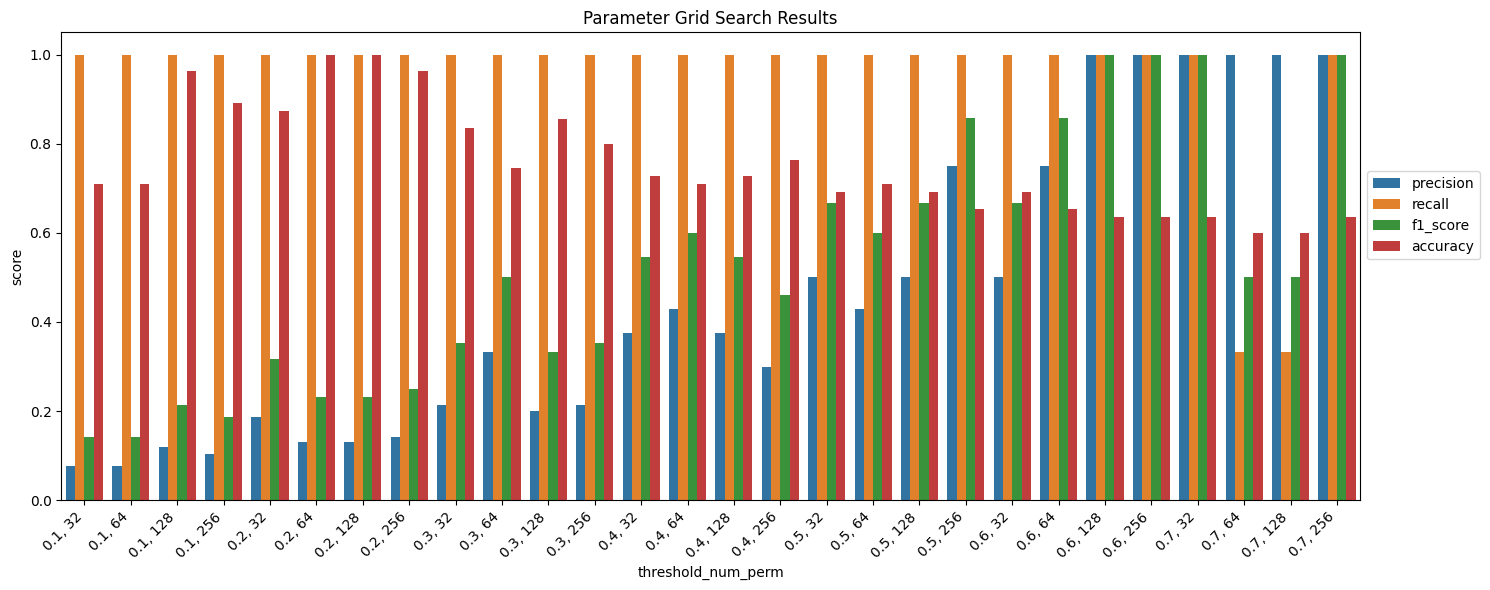

In [ ]:

# Melt the DataFrame to combine 'threshold' and 'num_perm' into a single column
melted_df = pd.melt(results_df, id_vars=['threshold', 'num_perm'],
                    value_vars=['precision', 'recall', 'f1_score', 'accuracy'],
                    var_name='metric', value_name='score')

# Create a new column combining 'threshold' and 'num_perm'
melted_df['threshold_num_perm'] = melted_df['threshold'].astype(str) + ', ' + melted_df['num_perm'].astype(str)

# Create the grouped bar plot using seaborn
plt.figure(figsize=(15, 6))
sns.barplot(x='threshold_num_perm', y='score', hue='metric',
            data=melted_df, errorbar=None)
plt.title('Parameter Grid Search Results')
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##4.6 Jaccard Similarity vs LSH Probabillity visualization

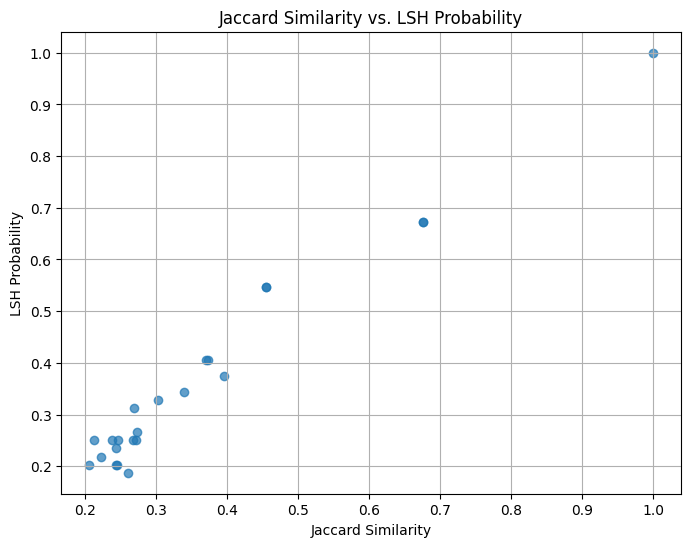

In [ ]:
#initialize minhashses
num_perm = 64
minhashes = {}
for user, songs in user_songs_dict.items():
    m = MinHash(num_perm=num_perm)
    for song in songs:
        m.update(str(song).encode('utf8'))
    minhashes[user] = m

# Initialize LSH
threshold = 0.2
lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)
for user, mh in minhashes.items():
    lsh.insert(user, mh)

#get candidate pairs by quering the keys for similar users
candidate_pairs = []
for user in user_songs_dict.keys():
    for other_user in lsh.query(minhashes[user]):
        if user != other_user and (other_user, user) not in candidate_pairs:  # Avoid duplicates
            candidate_pairs.append((user, other_user))

#calculate jaccard similarity and lsh probs f every pair
jaccard_similarities = []
lsh_probabilities = []

for user1, user2 in candidate_pairs:
    set1 = user_songs_dict[user1]
    set2 = user_songs_dict[user2]

    # Jaccard similarity
    jaccard = calculate_jaccard_similarity(set1, set2)
    jaccard_similarities.append(jaccard)

    # LSH probability (approximated as MinHash similarity)
    mh1 = minhashes[user1]
    mh2 = minhashes[user2]
    lsh_prob = mh1.jaccard(mh2)
    lsh_probabilities.append(lsh_prob)

# Plot Jaccard similarity vs. LSH probability
plt.figure(figsize=(8, 6))
plt.scatter(jaccard_similarities, lsh_probabilities, alpha=0.7)

plt.xlabel("Jaccard Similarity")
plt.ylabel("LSH Probability")
plt.title("Jaccard Similarity vs. LSH Probability")

plt.grid(True)
plt.show()

#5.Make model and train

##5.1 Compute user_weights based on the songs that have heard

In [ ]:
#user_weights_count = df.groupby('username')['track_id'].count()
#user_weights_mean = df.groupby('username')['rating'].mean()
#user_weights_diversity = df.groupby('username')['track_genre'].nunique()

#user_weights = (
 #   0.4 * (user_weights_count / user_weights_count.max()) +
 #   0.4 * (user_weights_mean / user_weights_mean.max()) +
 #   0.2 * (user_weights_diversity / user_weights_diversity.max())
#)


In [ ]:
user_weights=df.groupby('username')['track_id'].count()

#scale them to (0,1)
user_weights=user_weights/user_weights.max()
user_weights


username
0.0     0.803666
1.0     0.681647
2.0     0.220186
3.0     0.512930
4.0     1.000000
5.0     0.055235
6.0     0.025358
7.0     0.449912
8.0     0.025358
9.0     0.402712
10.0    0.038413
Name: track_id, dtype: float64

##5.2 Train an SVD model for every user


In [ ]:
reader=Reader(rating_scale=(1, 5))
#for every group
group_suggestions=[]#list for the suggestions of the group
for group in groups:
  group_recommendations={} #dictionary to store predictions for every user with weights
                           #in the group

  #for each user train and fit and svd algorithm
  for user in group:

    #filter train data for every user
    user_data=df[df['username']==user]


    #Create a DataFrame for Surprise package in the form [username, track_id, rating]
    user_surprise_data=user_data[['username', 'track_id', 'rating']]

    #fit
    data=Dataset.load_from_df(user_surprise_data, reader)
    trainset = data.build_full_trainset()
    svd = SVD()
    svd.fit(trainset)

    #predict
    predictions_train=svd.test(trainset.build_testset())
    #print(f"Group:", group)
    #print(predictions_train)

    #evaluate the prediction
    #accuracy.mse(predictions_train)

    #unseen tracks of the user
    unseen_tracks =df[~df['track_id'].isin(user_data['track_id'])]['track_id'].unique()
    #print(unseen_tracks)

    for track in unseen_tracks:
      #predict if match
      prediction = svd.predict(user, track)
      if track not in group_recommendations:
        group_recommendations[track]=[] #if the song does not included in the list, make a list for that
      group_recommendations[track].append((prediction.est,user_weights[user])) #append in the list the estimation and its weights


  #[(2.3476610548908505, 0.02952565343659245),
  #(2.7481380706904295, 0.5024201355275896),
  #(2.393017557153354, 0.036786060019361085)])
  #compute the weighted average for unseen items
  final_recommendations={}
  for track,predictions in group_recommendations.items():
    print(f"Group Recommendations for Track {track}: {predictions}")

    total_weight=0
    weighted_sum=0
    for prediction,weight in predictions:
      #print(f"Prediction: {prediction}, Weight: {weight}")
      weighted_sum+=prediction*weight
      #print(f"Track: {track}, Weighted Sum: {weighted_sum}")

      total_weight+=weight
    final_recommendations[track]=weighted_sum/total_weight
    #print(f"Weighted Sum: {weighted_sum}, Total Weight: {total_weight}, Weighted Mean: {final_recommendations[track]}")
  #append in group_recommendations
  group_suggestions.append(sorted(final_recommendations.items(), key=lambda x: x[1], reverse=True)[:10])







Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
Group Recommendations for Track 2211.0: [(3.0317246293863414, 0.44991212653778556), (3.0170643218500666, 0.40271152397690185), (2.980399409500062, 0.038413256339442634)]
Group Recommendations for Track 2212.0: [(3.0317246293863414, 0.44991212653778556), (3.0170643218500666, 0.40271152397690185), (2.980399409500062, 0.038413256339442634)]
Group Recommendations for Track 2213.0: [(3.0317246293863414, 0.44991212653778556), (3.0170643218500666, 0.40271152397690185), (2.980399409500062, 0.038413256339442634)]
Group Recommendations for Track 2214.0: [(3.0317246293863414, 0.44991212653778556), (3.0170643218500666, 0.40271152397690185), (2.980399409500062, 0.038413256339442634)]
Group Recommendations for Track 2215.0: [(3.0317246293863414, 0.44991212653778556), (3.0170643218500666, 0.40271152397690185), (2.980399409500062, 0.038413256339442634)]
Group Recommendations for Track 2216.0: [(3.0317246293863414, 0.44991212653778556), (3.01706432

In [ ]:
(group_recommendations)

{0.0: [(2.8073948624600438, 0.0253577705247301),
  (2.9821258637418726, 0.038413256339442634)],
 1.0: [(2.8073948624600438, 0.0253577705247301),
  (3.019103189726008, 0.40271152397690185),
  (2.9821258637418726, 0.038413256339442634)],
 2.0: [(2.8073948624600438, 0.0253577705247301),
  (3.019103189726008, 0.40271152397690185),
  (2.9821258637418726, 0.038413256339442634)],
 3.0: [(2.8073948624600438, 0.0253577705247301),
  (3.019103189726008, 0.40271152397690185),
  (2.9821258637418726, 0.038413256339442634)],
 4.0: [(2.8073948624600438, 0.0253577705247301),
  (3.019103189726008, 0.40271152397690185),
  (2.9821258637418726, 0.038413256339442634)],
 5.0: [(2.8073948624600438, 0.0253577705247301),
  (3.019103189726008, 0.40271152397690185),
  (2.9821258637418726, 0.038413256339442634)],
 6.0: [(2.8073948624600438, 0.0253577705247301),
  (2.9821258637418726, 0.038413256339442634)],
 7.0: [(2.8073948624600438, 0.0253577705247301),
  (3.019103189726008, 0.40271152397690185),
  (2.9821258637

In [ ]:
#print the top-10 suggestions for evefry group
for i, recommendations in enumerate(group_suggestions):
  print(f"Group {i},{recommendations}")

Group 0,[(1410.0, 3.060679581770189), (1436.0, 3.060679581770189), (1463.0, 3.060679581770189), (1540.0, 3.060679581770189), (1573.0, 3.060679581770189), (1603.0, 3.060679581770189), (1633.0, 3.060679581770189), (1634.0, 3.060679581770189), (1645.0, 3.060679581770189), (1693.0, 3.060679581770189)]
Group 1,[(2.0, 3.1361948092993197), (4.0, 3.1361948092993197), (12.0, 3.1361948092993197), (13.0, 3.1361948092993197), (14.0, 3.1361948092993197), (16.0, 3.1361948092993197), (17.0, 3.1361948092993197), (18.0, 3.1361948092993197), (21.0, 3.1361948092993197), (36.0, 3.1361948092993197)]
Group 2,[(4.0, 3.064773759423351), (9.0, 3.064773759423351), (18.0, 3.064773759423351), (21.0, 3.064773759423351), (28.0, 3.064773759423351), (36.0, 3.064773759423351), (47.0, 3.064773759423351), (51.0, 3.064773759423351), (99.0, 3.064773759423351), (100.0, 3.064773759423351)]
Group 3,[(1420.0, 3.0460923429026776), (1463.0, 3.0460923429026776), (1540.0, 3.0460923429026776), (2058.0, 3.0460923429026776), (2207.0

###5.2.1 Train an svd model for every group

In [ ]:
#train an svd for every group
#training data foer every group

reader=Reader(rating_scale=(1, 5))
group_recommendations_new=[]

for group in groups:
  group_data=df[df['username'].isin(group)]


  data=Dataset.load_from_df(group_data[['username', 'track_id', 'rating']], reader)
  trainset = data.build_full_trainset()

  #train an svd
  svd = SVD()
  svd.fit(trainset)

  #prediction for training set
  predictions_train=svd.test(trainset.build_testset())

  track_predictions=defaultdict(list)

  #for every user in the group
  for user in group:

    #user_data
    user_data=group_data[group_data['username']==user]
    #unseen tracks of the user
    unseen_tracks =df[~df['track_id'].isin(group_data[group_data['username']==user]['track_id'])]['track_id'].unique()

    for track in unseen_tracks:
      #predict if match
      prediction = svd.predict(user, track)
      if track not in track_predictions:
        track_predictions[track]=[] #if the song does not included in the list, make a list for that
      track_predictions[track].append((prediction.est,user_weights[user])) #append in the list the estimation

  #compute the weighted average for unseen items
  final_recommendations={}
  for track,predictions in track_predictions.items():
    total_weight=0
    weighted_sum=0
    for prediction,weight in predictions:
      weighted_sum+=prediction*weight
      total_weight+=weight
    final_recommendations[track]=weighted_sum/total_weight

  #append in group_recommendations
  group_recommendations_new.append(sorted(final_recommendations.items(), key=lambda x: x[1], reverse=True)[:10])




In [ ]:
#print the top-10 suggestions for evefry group
for i, recommendations in enumerate(group_recommendations_new):
  print(f"Group {i},{recommendations}")

Group 0,[(78.0, 3.821895937190142), (171.0, 3.789333184842249), (429.0, 3.6761726334859635), (715.0, 3.619310726508029), (255.0, 3.596380392759917), (436.0, 3.579447721066656), (1645.0, 3.5432486314413767), (1375.0, 3.531709499544692), (187.0, 3.5047532289879384), (128.0, 3.502061713337043)]
Group 1,[(56.0, 3.8905029959500386), (696.0, 3.843848716009378), (1304.0, 3.7866702951932267), (2500.0, 3.779789047055431), (712.0, 3.7493780758164044), (1364.0, 3.7210293330731687), (1268.0, 3.706779304122456), (70.0, 3.6878342517643232), (1131.0, 3.6407914914949386), (1350.0, 3.629178155948796)]
Group 2,[(136.0, 3.6144815251814757), (2114.0, 3.596660951132354), (957.0, 3.588934696829601), (2896.0, 3.5801467723625895), (381.0, 3.5800534108504287), (1727.0, 3.5505264227916915), (1273.0, 3.534772800950037), (948.0, 3.5271038439605817), (1422.0, 3.504831195564483), (1841.0, 3.4874139936290915)]
Group 3,[(6.0, 3.615436004988181), (163.0, 3.5685664985650143), (1712.0, 3.498039012064212), (970.0, 3.4843

##5.3 Evaluation /Coverage

In [ ]:
def coverage(group_suggestions,group_data,threshold):
  coverage_scores=[]

  for i,recommendations in enumerate(group_suggestions):
   # print(i)
    group=groups[i]

    coverage_leiked_by_all=0
    coverage_leiked_by_most=0
    total_recommendations=len(recommendations)

    for track, _ in recommendations:
      #see how many users have rated the song  >= threshold
      likes=sum(1 for user in group if svd.predict(user,track).est>=threshold)

      if likes==len(group):
        coverage_leiked_by_all+=1

      if likes>=(len(group)//2): #if hald of users in the group liked the song
        coverage_leiked_by_most+=1


    coverage_scores.append((coverage_leiked_by_all/total_recommendations,
                            coverage_leiked_by_most/total_recommendations))

  return coverage_scores


In [ ]:
group_data=[]
for group in groups:
  group_data.append(df[df['username'].isin(groups[0])])
#group_data[0].head()

In [ ]:
coverage_scores=coverage(group_recommendations_new,group_data,3.0)


In [ ]:
for i,group in enumerate (groups):
  print(f"Group {i}:")
  print(f"Coverage liked by all: {coverage_scores[groups.index(group)][0]}")
  print(f"Coverage liked by most: {coverage_scores[groups.index(group)][1]}")

Group 0:
Coverage liked by all: 0.0
Coverage liked by most: 0.0
Group 1:
Coverage liked by all: 0.0
Coverage liked by most: 0.0
Group 2:
Coverage liked by all: 0.0
Coverage liked by most: 0.0
Group 3:
Coverage liked by all: 0.0
Coverage liked by most: 0.0
Group 4:
Coverage liked by all: 0.0
Coverage liked by most: 0.0
Group 5:
Coverage liked by all: 0.2
Coverage liked by most: 0.2
Group 6:
Coverage liked by all: 0.0
Coverage liked by most: 0.1
Group 7:
Coverage liked by all: 0.2
Coverage liked by most: 1.0
Group 8:
Coverage liked by all: 0.1
Coverage liked by most: 0.4
Group 9:
Coverage liked by all: 0.2
Coverage liked by most: 0.2
Group 10:
Coverage liked by all: 0.0
Coverage liked by most: 0.0
Group 11:
Coverage liked by all: 0.3
Coverage liked by most: 0.3
Group 12:
Coverage liked by all: 0.1
Coverage liked by most: 0.1
Group 13:
Coverage liked by all: 0.3
Coverage liked by most: 0.3
Group 14:
Coverage liked by all: 0.0
Coverage liked by most: 0.0
Group 15:
Coverage liked by all: 0.

##5.4 Evaluation/Diversity

In [ ]:
#measure evaluation across diveristy
def diversity(group_suggestions, df):
  diversity_scores=[]

  for group_recs in group_suggestions:
    track_ids = [id for id,_ in group_recs]

    #Handle where there are no track_ids
    if not track_ids:
      diversity_scores.append(0)
      continue

    #create a matrix where rows are songs ids and columns are features
    song_features_df=df.loc[df['track_id'].isin(track_ids), ['track_id', 'artists', 'album_name']].drop_duplicates()


    diversity_score = 0
    #Comparison between genres

    for i in range(len(track_ids) - 1):
      for j in range(i + 1, len(track_ids)):
        #compare pairwise genres
        song1_features = song_features_df[song_features_df['track_id'] == track_ids[i]]['album_name'].values
        song2_features = song_features_df[song_features_df['track_id'] == track_ids[j]]['album_name'].values

        #if the 2 songs are valid and different
        if song1_features.size > 0 and song2_features.size > 0 and song1_features[0] != song2_features[0]:
          diversity_score += 1

          #final diveristy score is computed as the number of diverse pairs
          #devided by the total number of possible pairs of tracks (n(n-1)/2)
          #if there is only one track the diversity is max,1

    diversity_scores.append(diversity_score / (len(track_ids) * (len(track_ids) - 1) / 2) if len(track_ids) > 1 else 1)
  return diversity_scores


In [ ]:
diversity_scores=diversity(group_recommendations_new,df)

In [ ]:
# Print diversity scores for each group
for i, diversity_score in enumerate(diversity_scores):
  print(f"Group {i + 1}: Diversity Score = {diversity_score:.4f}")


Group 1: Diversity Score = 0.9778
Group 2: Diversity Score = 1.0000
Group 3: Diversity Score = 1.0000
Group 4: Diversity Score = 1.0000
Group 5: Diversity Score = 1.0000
Group 6: Diversity Score = 1.0000
Group 7: Diversity Score = 1.0000
Group 8: Diversity Score = 1.0000
Group 9: Diversity Score = 1.0000
Group 10: Diversity Score = 1.0000
Group 11: Diversity Score = 1.0000
Group 12: Diversity Score = 1.0000
Group 13: Diversity Score = 1.0000
Group 14: Diversity Score = 1.0000
Group 15: Diversity Score = 1.0000
Group 16: Diversity Score = 1.0000
Group 17: Diversity Score = 1.0000
Group 18: Diversity Score = 1.0000
Group 19: Diversity Score = 0.9778
Group 20: Diversity Score = 1.0000
Group 21: Diversity Score = 1.0000
Group 22: Diversity Score = 1.0000
Group 23: Diversity Score = 0.9778
Group 24: Diversity Score = 1.0000
Group 25: Diversity Score = 1.0000
Group 26: Diversity Score = 1.0000
Group 27: Diversity Score = 1.0000
Group 28: Diversity Score = 1.0000
Group 29: Diversity Score = 1

##5.5 Evaluation/Consensus

Αξιολογεί σε ποιο βαθμό τα μέλη της ομάδας έχουν καταλήξει σε συμφωνία σε σχέση με τις προτεινόμενες προτάσεις.

In [ ]:
def consensus(group_recommendations, tracks,max_rating=5):

  track_consensus_scores={}

  for track, l in group_recommendations.items():

    #extract only the rating from the group recommendations
    #ignoring the weights
    predicted_ratings=[pred for pred, _ in l]

    #calclulate the pairwise absolute differences in predicted ratings
    pairwise_diffs=[]
    #print(f"predicted_ratings {predicted_ratings}")
    #print(f"len of predicted_ratings {len(predicted_ratings)}")
    if len(predicted_ratings)<2:
      continue
    for i in range(len(predicted_ratings)-1):
      for j in range(i+1,len(predicted_ratings)):
        #print(pairwise_diffs)
        diff=abs(predicted_ratings[i]-predicted_ratings[j])
        #print(f"diff {diff}")
        pairwise_diffs.append(diff)

    #average pairwise differenses
    avg_pairwise_diff=sum(pairwise_diffs)/len(pairwise_diffs)

    #calculate consensus score
    consensus_score=1-avg_pairwise_diff/(max_rating * (len(group)-1)/2)

    track_consensus_scores[track]=consensus_score

  return track_consensus_scores

In [ ]:
#group_suggestions is a list where each element corresponds to a list of recommended tracks for a group
for i, (group, suggestions) in enumerate(zip(groups, group_recommendations_new)):
    # Print group information
    print(f"Group {i + 1} (Users: {group}):")

    # Get only the track IDs from suggestions to pass into the consensus function
    tracks_in_suggestions = [track for track, _ in suggestions]

    # Calculate the consensus scores only for the tracks in suggestions
    group_consensus_scores = consensus(track_predictions, tracks_in_suggestions)

    # Print consensus score for each track in this group's suggestions
    for track, _ in suggestions:

        print(f"Track {track}: Consensus Score = {group_consensus_scores.get(track,'none')}")


Group 1 (Users: (0.0, 1.0, 2.0)):
Track 78.0: Consensus Score = 0.9735666733849819
Track 171.0: Consensus Score = 0.9735666733849819
Track 429.0: Consensus Score = 0.9049537702254975
Track 715.0: Consensus Score = 0.9735666733849819
Track 255.0: Consensus Score = 0.9735666733849819
Track 436.0: Consensus Score = 0.9950916830632744
Track 1645.0: Consensus Score = 0.9735666733849819
Track 1375.0: Consensus Score = none
Track 187.0: Consensus Score = 0.9735666733849819
Track 128.0: Consensus Score = 0.9735666733849819
Group 2 (Users: (0.0, 1.0, 3.0)):
Track 56.0: Consensus Score = 0.952794136547127
Track 696.0: Consensus Score = 0.9735666733849819
Track 1304.0: Consensus Score = 0.9735666733849819
Track 2500.0: Consensus Score = 0.9821146684788638
Track 712.0: Consensus Score = 0.9735666733849819
Track 1364.0: Consensus Score = 0.9735666733849819
Track 1268.0: Consensus Score = 0.9735666733849819
Track 70.0: Consensus Score = 0.9735666733849819
Track 1131.0: Consensus Score = 0.9778564305

##5.6 Evaluation/Fairness

In [ ]:
def fairness(group_suggestions, df, threshold=3.0):
  fairness_scores = []

  for group_idx , suggestions in enumerate(group_suggestions):
    group = groups[group_idx]
    group_recs = [track for track, _ in suggestions]

    satisfied_users=0

    for user in group:

      #measure how many users in the group have rated the suggested song above threshold
      user_ratings = df[(df['username'] == user) & (df['track_id'].isin(group_recs))]

      ratings_count=user_ratings[user_ratings['rating']>threshold].shape[0]

      #if the user is satisfied from one song or more
      if ratings_count>0 :
        satisfied_users+=1

    fairness_scores.append(satisfied_users/len(group))

  return fairness_scores





In [ ]:
#dispaly fairness_score for each group
fairness_scores=fairness(group_recommendations_new,df)
for i, fairness_score in enumerate(fairness_scores):
  print(f"Group {i + 1}: Fairness Score = {fairness_score:.4f}")

Group 1: Fairness Score = 1.0000
Group 2: Fairness Score = 1.0000
Group 3: Fairness Score = 1.0000
Group 4: Fairness Score = 0.6667
Group 5: Fairness Score = 1.0000
Group 6: Fairness Score = 1.0000
Group 7: Fairness Score = 0.6667
Group 8: Fairness Score = 1.0000
Group 9: Fairness Score = 1.0000
Group 10: Fairness Score = 1.0000
Group 11: Fairness Score = 0.6667
Group 12: Fairness Score = 1.0000
Group 13: Fairness Score = 1.0000
Group 14: Fairness Score = 1.0000
Group 15: Fairness Score = 0.6667
Group 16: Fairness Score = 1.0000
Group 17: Fairness Score = 1.0000
Group 18: Fairness Score = 1.0000
Group 19: Fairness Score = 0.6667
Group 20: Fairness Score = 0.6667
Group 21: Fairness Score = 1.0000
Group 22: Fairness Score = 1.0000
Group 23: Fairness Score = 1.0000
Group 24: Fairness Score = 1.0000
Group 25: Fairness Score = 1.0000
Group 26: Fairness Score = 1.0000
Group 27: Fairness Score = 1.0000
Group 28: Fairness Score = 1.0000
Group 29: Fairness Score = 1.0000
Group 30: Fairness Scor

###M-prop fairness

In [ ]:
def m_prop(m_items, suggestions, df, threshold=3.0):
  m_prop_scores = []
  for group_idx , suggestions in enumerate(group_recommendations_new):
    group = groups[group_idx]
    group_recs = [track for track, _ in suggestions]

    gp = 0
    g = len(group)
    for user in group:
      user_ratings = df[(df['username'] == user) & (df['track_id'].isin(group_recs))]
      ratings_count = user_ratings[user_ratings['rating'] > threshold].shape[0] #shape[0] holds the number of lins of the df
                                                                                #that the user has rated songs > th

      if ratings_count >= m_items:
        gp += 1

    m_prop_scores.append(gp / g)

  return m_prop_scores

In [ ]:
m_prop_scores=m_prop(2, group_recommendations_new,df)
for i, m_prop_score in enumerate(m_prop_scores):
  print(f"Group {i + 1}: M-Prop Score = {m_prop_score:.4f}")

Group 1: M-Prop Score = 0.6667
Group 2: M-Prop Score = 1.0000
Group 3: M-Prop Score = 1.0000
Group 4: M-Prop Score = 0.6667
Group 5: M-Prop Score = 1.0000
Group 6: M-Prop Score = 0.6667
Group 7: M-Prop Score = 0.6667
Group 8: M-Prop Score = 1.0000
Group 9: M-Prop Score = 1.0000
Group 10: M-Prop Score = 1.0000
Group 11: M-Prop Score = 0.6667
Group 12: M-Prop Score = 1.0000
Group 13: M-Prop Score = 1.0000
Group 14: M-Prop Score = 1.0000
Group 15: M-Prop Score = 0.6667
Group 16: M-Prop Score = 1.0000
Group 17: M-Prop Score = 0.6667
Group 18: M-Prop Score = 1.0000
Group 19: M-Prop Score = 0.3333
Group 20: M-Prop Score = 0.6667
Group 21: M-Prop Score = 1.0000
Group 22: M-Prop Score = 1.0000
Group 23: M-Prop Score = 1.0000
Group 24: M-Prop Score = 1.0000
Group 25: M-Prop Score = 1.0000
Group 26: M-Prop Score = 0.6667
Group 27: M-Prop Score = 1.0000
Group 28: M-Prop Score = 1.0000
Group 29: M-Prop Score = 1.0000
Group 30: M-Prop Score = 0.6667
Group 31: M-Prop Score = 1.0000
Group 32: M-Prop 

###M-envy fairness

In [ ]:
#calculate the top  x% suggestions per group

def top_x_percent_suggestions(group_suggestions, percentage):

  top_suggestions_per_group = set()
  for group_rec in group_suggestions:
      # Sort the suggestions in descending order based on the predicted rating.
      sorted_recs = sorted(group_rec, key=lambda x: x[1], reverse=True)

      # Calculate the number of suggestions to keep.
      num_to_keep = int(len(sorted_recs) * (percentage / 100))

      # Handle cases where num_to_keep is 0.
      num_to_keep = max(1, num_to_keep)

      top_suggestions_per_group.update([track_id for track_id , _ in sorted_recs[:num_to_keep]])
  return top_suggestions_per_group



In [ ]:
tops={}
for i, (group, suggestions) in enumerate(zip(groups, group_recommendations_new)):
    # Print group information
    tops[i]=top_x_percent_suggestions([suggestions], 25) #wrap suggestions into a list to match the input type

In [ ]:
tops

{0: {78.0, 171.0},
 1: {56.0, 696.0},
 2: {136.0, 2114.0},
 3: {6.0, 163.0},
 4: {2877.0, 3071.0},
 5: {567.0, 1197.0},
 6: {2914.0, 2933.0},
 7: {400.0, 851.0},
 8: {803.0, 2207.0},
 9: {912.0, 1350.0},
 10: {169.0, 1154.0},
 11: {687.0, 2494.0},
 12: {182.0, 1165.0},
 13: {364.0, 1003.0},
 14: {873.0, 1005.0},
 15: {1133.0, 1276.0},
 16: {970.0, 2596.0},
 17: {220.0, 793.0},
 18: {598.0, 1250.0},
 19: {40.0, 569.0},
 20: {993.0, 1327.0},
 21: {180.0, 2589.0},
 22: {598.0, 835.0},
 23: {654.0, 1132.0},
 24: {760.0, 1248.0},
 25: {787.0, 1323.0},
 26: {956.0, 1384.0},
 27: {1416.0, 1728.0},
 28: {928.0, 1307.0},
 29: {1995.0, 2265.0},
 30: {3238.0, 3249.0},
 31: {529.0, 680.0},
 32: {1463.0, 3238.0},
 33: {888.0, 2605.0},
 34: {2592.0, 2595.0},
 35: {425.0, 2267.0},
 36: {2595.0, 2601.0},
 37: {104.0, 596.0},
 38: {1463.0, 2601.0},
 39: {1199.0, 1331.0},
 40: {917.0, 1130.0},
 41: {411.0, 736.0},
 42: {251.0, 695.0},
 43: {2595.0, 2603.0},
 44: {261.0, 2799.0},
 45: {2487.0, 2598.0},
 

In [ ]:
def m_envy_fairness(group_suggestions, df, top_x_percent=0.25, m_items=3, threshold=3.0):

  top_group_suggestions=top_x_percent_suggestions(group_suggestions, top_x_percent)
  m_envy_scores = []

  for group_idx , suggestions in enumerate(group_suggestions):
    group = groups[group_idx]
    group_recs = tops[group_idx]

    envy_count=0
    for user in group:
      user_ratings = df[(df['username'] == user) & (df['track_id'].isin(group_recs))]
      ratings_count = user_ratings[user_ratings['rating'] > threshold].shape[0]

      if ratings_count >= m_items:
        envy_count += 1

    envy_count=envy_count/len(group)
    m_envy_scores.append(envy_count / len(group))

  return m_envy_scores





In [ ]:
#count the envy scores for every group and print
m_envy_scores=m_envy_fairness(group_recommendations_new,df)
for i, m_envy_score in enumerate(m_envy_scores):
  print(f"Group {i + 1}: M-Envy Score = {m_envy_score:.4f}")

Group 1: M-Envy Score = 0.1111
Group 2: M-Envy Score = 0.2222
Group 3: M-Envy Score = 0.0000
Group 4: M-Envy Score = 0.1111
Group 5: M-Envy Score = 0.0000
Group 6: M-Envy Score = 0.0000
Group 7: M-Envy Score = 0.0000
Group 8: M-Envy Score = 0.0000
Group 9: M-Envy Score = 0.1111
Group 10: M-Envy Score = 0.2222
Group 11: M-Envy Score = 0.1111
Group 12: M-Envy Score = 0.1111
Group 13: M-Envy Score = 0.0000
Group 14: M-Envy Score = 0.0000
Group 15: M-Envy Score = 0.1111
Group 16: M-Envy Score = 0.2222
Group 17: M-Envy Score = 0.0000
Group 18: M-Envy Score = 0.1111
Group 19: M-Envy Score = 0.1111
Group 20: M-Envy Score = 0.0000
Group 21: M-Envy Score = 0.1111
Group 22: M-Envy Score = 0.1111
Group 23: M-Envy Score = 0.2222
Group 24: M-Envy Score = 0.0000
Group 25: M-Envy Score = 0.1111
Group 26: M-Envy Score = 0.1111
Group 27: M-Envy Score = 0.0000
Group 28: M-Envy Score = 0.1111
Group 29: M-Envy Score = 0.1111
Group 30: M-Envy Score = 0.0000
Group 31: M-Envy Score = 0.0000
Group 32: M-Envy 

#6.Paper icdm-2016 GR-INC UP-INC

##GR-INC

Ο GR-INC αλγόριθμος συνδυάζει τις φάσεις I2G και P2G επαναληπτικά.

Στην φάση **I2G** υπολογίζεται η πιθανότητα κάθε αντικειμένου να επιλεγεί από το group βασιζόμενος στις ατομικές προτάσεις του κάθε χρήστη. Χρησιμοποείται η εξίσωση (2) ,δηλαδή η πιθανότητα ενός αντικιεμένου να επιλεχθέι είναι ένα σταθμισμένο άθροισμα όλων των πιθανοτήτων κάθε χρήστη του group με βάρος την εμπειρία κάθε χρήστη στην κατηγορία που ανήκει το αντικείμενο που εξετάζεται.

Στην φάση **P2G** συνδυάζονται τα αντικείμενα που επιλέχθηκαν σε πακέτα.Λαμβάνει υπόψη του 3 παράγοντες.



1.   Τις προτιμήσεις των χρηστών
2.   Δικαιοσύνη μεταξύ των μελών
3.   Βιωσιμότητα του πακέτου ( Pr(I, V | U, C) )


Τέλος διατηρεί τα κορυφάια k πακέτα στην λίστα αποτελεσμάτων



In [ ]:
# def calculate_item_to_group_probabillities(group, user_ratings):
#   i2g_prob=defaultdict(list) #track id as a key rating value as a value
#   group_probabillities={}
#   for user in group:

#     #Compute P(i|u) for every user
#     user_data=df[df['username']==user]
#     total_rating=user_data['rating'].sum()

#     for _,row in user_data.iterrows():
#       track_id=row['track_id']
#       rating=row['rating']

#       #assuming equal activity for simplicity
#       prob_i_given_u=(1/3)*rating
#       i2g_prob[track_id].append(prob_i_given_u)
#       #print(track_id,rating)

#   #calculate total propabillity for the group P(i|u) as the average of the probs
#   #of the users in the group
#   for track_id,probs in i2g_prob.items():
#     group_probabillities[track_id]=sum(probs)/len(probs)


#   return group_probabillities







In [ ]:
# def gr_inc_recommendations(group, user_ratings, top_k):
#
#   i2g_prob=calculate_item_to_group_probabillities(group, user_ratings)

#   #ranking
#   ranked_items=sorted(i2g_prob.items(),key=lambda x:x[1],reverse=True)
#   #print(ranked_items)

#   #recommend the top_k
#   top_k_items=ranked_items[:top_k]

#   return top_k_items

In [ ]:
# group=groups[0]
# recommendations=gr_inc_recommendations(group,df, top_k=8)
# print(f"recommendations for group 0:{recommendations}")



In [ ]:
def group_items_by_genre(df):

  #group the songs based on genre
  items_by_category=df.groupby('track_genre')['track_id'].apply(list).to_dict()
  return items_by_category


In [ ]:
items=print(group_items_by_genre(df))

In [ ]:
#Compute P(i|U,ci) for each item
def compute_item_to_group_probability(group, items, user_ratings):
  probabillities={}
  for item in items:

    #assuming equal probs for every user
    prob=sum(user_ratings[(user_ratings['username']==user)
                        & (user_ratings['track_id']==item)]['rating'].sum() *1/3
             for user in group)

    #print(prob)
    probabillities[item]=prob
    #print(probabillities)

  #normalize the probabilities
  total_prob=sum(probabillities.values())
  for item in probabillities:
    probabillities[item]/=total_prob
  return probabillities

In [ ]:
# Incremental I2G
def gr_inc_i2g(group, items_by_category, user_ratings, k):
    """
    Υπολογίζει τα top-k τραγούδια για κάθε κατηγορία σε μια ομάδα.
    """
    category_probabilities = {}
    for category, items in items_by_category.items():
        #print(category, items) #alt-rock [2594.0, 2207.0]
        probabilities = compute_item_to_group_probability(group, items, user_ratings)
        #print(f"probabilieties for category {category}={probabilities}")

        #sorted probabilieties in descending order
        sorted_probs= sorted(probabilities.items(), key=lambda x: x[1], reverse=True)
        category_probabilities[category] = sorted_probs[:k]
    return category_probabilities



In [ ]:
from itertools import product

#GR-INC implementation
def gr_inc(group, user_ratings, k):

    #group tracks by genre
    items_by_category = group_items_by_genre(user_ratings)
    categories = list(items_by_category.keys())

    # I2G Phase: compute top-k packages from every category to  make the packages
    category_top_items = gr_inc_i2g(group, items_by_category, user_ratings, k)

    # P2G Phase: Making packages
    packages = []
    for package in product(*(category_top_items[cat] for cat in categories)):
      #use cartesian product
      #to do all the possible combinations  from top items per caegory
        #print(category_top_items[cat] for cat in categories)()
        package_items = [item for item, _ in package] #extract item ignoring the score
        package_score = sum(score for _, score in package) #extract score ignoring the item
        packages.append((package_items, package_score))

    #select only the top-k packages
    packages.sort(key=lambda x: x[1], reverse=True)
    return packages[:k]

In [ ]:
group = groups[0]
for user in group:


    user_data=df[df['username']==user]
    user_ratings=user_data[['username', 'track_id','track_genre' ,'rating']]

top_k =4
top_k_packages=gr_inc(group, user_ratings, top_k)
print("Top-k Packages for GR-INC:")
for package in top_k_packages:
    print(f"Tracks: {package[0]}, Score: {package[1]:.2f}")

##UP-INC

Βήματα αλγορίθμου

1. Επιλογή αντιπροσωπευτικού χρήστη: Ο αλγόριθμος επιλέγει έναν αντιπροσωπευτικό χρήστη για την ομάδα, οποίος θα αποφασίσει για το πακέτο. Η πιθανότητα επιλογής αυτού του χρήστη υπολογίζεται με βάση την επιρροή του σε όλες τις κατηγορίες αντικειμένων.

2. Υπολογισμός Πιθανοτήτων: Ο UP-INC υπολογίζει την πιθανότητα ενός πακέτου να επιλεγεί από τον αντιπροσωπευτικό χρήστη, χρησιμοποιώντας τις προτιμήσεις του για τα αντικείμενα που περιλαμβάνονται στο πακέτο. Αυτό γίνεται με την εξίσωση:
Pr(I∣U,C)=∑u∈U​Pr(u∣U,C)⋅Pr(I∣u,C)
όπου Pr(I∣u,C) είναι η πιθανότητα επιλογής του πακέτου από τον χρήστη u.

3. Δύο κύριες φάσεις:

   **P2U phase:** Για κάθε χρήστη υπολογίζει τις πιθανότητες επιλογής των πακέτων

   **I2G phase:** Συνδυάζει τις πιθανότητες για να βρει τα καλύτερα πακέτα για την ομάδα

4. Αποτελεσματικότητα: Ο UP-INC είναι
   σχεδιασμένος να είναι πιο αποδοτικός από τον UP-BA, καθώς υπολογίζει τις πιθανότητες με έναν πιο στοχευμένο και σταδιακό τρόπο, μειώνοντας την υπολογιστική πολυπλοκότητα.

In [ ]:
def calculate_user_influence(user,category_items):
  #print(category_items.head(5))
  user_category_ratings=category_items[category_items['username']==user]['rating'].count()
  total_category_ratings=category_items['rating'].count()
  return user_category_ratings/total_category_ratings if total_category_ratings>0 else 0

In [ ]:
def calculate_package_probability(user, package, category_items):
  """
  Υπολογίζει την πιθανότητα ενός πακέτου να επιλεγεί από τον χρήστη.
  """
  total_prob = 1
  for item in package:
    item_rating = category_items[(category_items['username'] == user)
                               & (category_items['track_id'] == item)]['rating'].mean()
    if not np.isnan(item_rating):
      total_prob *= item_rating
    else:
      total_prob = 0.01 #low possibility for this item , which is not rated
      #break;
  return total_prob

In [ ]:
def combine_user_package_probabilities(group, package, category_items):
    #combine user probabilities to calculate the probability of the package
    total_prob = 0
    total_influence = 0
    for user in group:
        influence = calculate_user_influence(user, category_items)
        user_prob = calculate_package_probability(user, package, category_items)
        total_prob += influence * user_prob
        total_influence += influence
    return total_prob / total_influence if total_influence > 0 else 0


**Διαφορά GR-INC με τον UP-INC**

Ο αλγόριθμος GR-INC βασίζεται σε ένα μοντέλο που επιλέγει αντικέιμνα ανεξάρτητα, εστιάζοντας στις προτιμήσεις ενός αντιπροσωπευτικού χρήστη. Ο χρήστης αυτός επιλέγεται με βάση την εμπειρία του και την επιρροή του στην κατηγορία των αντικειμένων. Αντίθετα ο UP-INC επιλέγει πρώτα έναν αντιπροσωπευτικό χρήστη για την ομάδα και στην συνέχεια αυτός ο χρήστης αποφασίζει για ολόκληρο το πακέτο. Η επιλογή των αντικειμένων γίνεται με βάση τις προτιμήσεις αυτού του χρήστη και η επιρροή του υπολογίζεται σε σχέση με όλες τις κατηγορίες αντικειμένων.  


In [ ]:
def up_inc(group, user_ratings, k):
    #group items by category
    items_by_category=group_items_by_genre(user_ratings)
    categories=list(items_by_category.keys())

    package_probabilities=[]

  # P2U Phase: Υπολογισμός πιθανότητας πακέτων για κάθε χρήστη
    for user in group:
        user_probabilities = []
        for category, items in items_by_category.items():
            for item in items:
                prob = calculate_package_probability(user, [item], user_ratings)
                heapq.heappush(user_probabilities, (-prob, item))



        #select k top items for the user
        user_top_items=[heapq.heappop(user_probabilities)[1] for _ in range(min(k, len(user_probabilities)))]
        package_probabilities.append((user,user_top_items))
    print(f"User {user} top items: {user_top_items}")
    #P2G phase:Combine packages for th group
    final_packages=[]
    seen_packages=set()
    for package_comb in product(*(user_top for _, user_top in package_probabilities)):
      package_items=tuple(sorted(set(item for item in package_comb))) #sorted unique items
      if package_items in seen_packages:
       continue
      seen_packages.add(package_items)
      package_score=combine_user_package_probabilities(group, package_items, user_ratings)
      final_packages.append((package_items,package_score))
      #print(f"Package:{package}, Score:{score}")
    #print(f"Seen packages:{len(seen_packages)}")

    final_packages.sort(key=lambda x:x[1],reverse=True)
    return final_packages[:k]



In [ ]:
group = groups[0]
user_data = df[df['username'].isin(group)]
top_k = 4

top_k_packages = up_inc(group, user_data, top_k)

print("Top-k Packages for UP-INC:")
for i, (package, score) in enumerate(top_k_packages):
    print(f"Package {i + 1}: Tracks: {package}, Score: {score:.2f}")
